**Table of contents**<a id='toc0_'></a>    
- [Purpose of the notebook](#toc1_)    
- [Removal of samples outside of physiological range](#toc2_)    
- [MAD phase-based artefact detection](#toc3_)    
  - [MAD phase-based velocity artifact detection](#toc3_1_)    
  - [MAD phase-based pupil size filtering](#toc3_2_)    
  - [Conclusions](#toc3_3_)    
- [MAD rolling window outlier detection](#toc4_)    
  - [Rolling window MAD for pupil velocity](#toc4_1_)    
  - [Rolling window MAD for pupil size](#toc4_2_)    
- [Conclusions: pipeline for artifact removal](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Purpose of the notebook](#toc0_)

It's a notebook for developing and demonstrating functions for detecting and removing artifacts. Functionality is demonstrated on data from participant 201.

Functions used below have now been condensed into preprocessing_utils and visualisation_utils, so you can use them in a separate notebook or script as needed.

To get data used here, run load_and_resample.py script with saving raw data enabled.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pupilprep_utilities.loading_utils as load
import pupilprep_utilities.preprocessing_utils as prep

participant_list = [200, 201, 202, 204, 205, 206, 207, 209, 210, 211, 212, 213]
data_dir = "./results/new/"

# <a id='toc2_'></a>[Removal of samples outside of physiological range](#toc0_)

Artifacts can be found through searching for datapoints where pupil size is out of physiological ranges or has a sudden change in value. In this section, I will write a function for non-physiological pupil size removal. Physiological ranges are between 2 and 8 mm, some sources also give 1.5 - 9 mm, e.g. https://link.springer.com/article/10.3758/s13428-018-1075-y. 

I chose to remove based on range of 1.5 - 9 mm. Every sample outside of this range is replaced with NaN. This should be done on data that hasn't been resampled yet, as such artifacts may undergo averaging when data is binned for the resampling procedure. Then they could be flattened and remain undetected later while influencing signal shape.

In [3]:
def remove_non_physio_size(data_df):
    data_df.loc[
        (data_df["Stim eye - Size Mm"] < 1.5) | (data_df["Stim eye - Size Mm"] > 9),
        "Stim eye - Size Mm",
    ] = pd.NA
    return data_df

In [ ]:
data_dir = "./results/new/"
data_suffix = "_recording_data.csv"

data_path = os.path.join(data_dir, str(201) + data_suffix)
data_df = pd.read_csv(data_path)

In [ ]:
data_df = remove_non_physio_size(data_df)

In [ ]:
data_df[data_df["Stim eye - Size Mm"] < 1.5]

,Unnamed: 0,Overall time Sec,Sequence time Sec,Experiment state,Sequence index,Sequences count,Excitation index,Excitation label - Left,Excitation label - Right,Left - Is found,...,Filepath,Recording id,Participant id,Block,Test,Trial phase,Trial type,Trial no,Trial time Sec,Stim eye - Size Mm


In [ ]:
data_df[data_df["Stim eye - Size Mm"] > 9]

,Unnamed: 0,Overall time Sec,Sequence time Sec,Experiment state,Sequence index,Sequences count,Excitation index,Excitation label - Left,Excitation label - Right,Left - Is found,...,Filepath,Recording id,Participant id,Block,Test,Trial phase,Trial type,Trial no,Trial time Sec,Stim eye - Size Mm


No rows outside of required range remain.

# <a id='toc3_'></a>[MAD phase-based artefact detection](#toc0_)

MAD is a measure denoting median absolute deviation. It is similar to z-score, however it doesn't make assumptions about the distribution of data and it is more robust to outliers. In this section, I will develop and test an approach where I compute MAD outlier thresholds for pupil velocity and pupil size, separating the signal into three trial phases: pre-stimulation, stimulation and post-stimulation. The reasoning is that the nature of the signal may be alike based on phase - I expect that each of them will have different ranges of velocity/size due to response to light and later relaxation from the response.

## <a id='toc3_1_'></a>[MAD phase-based velocity artifact detection](#toc0_)

For MAD based velocity artefact detection as described here: https://pmc.ncbi.nlm.nih.gov/articles/PMC6538573/ (221 cit.), I need to calculate dilation/constriction speed of the pupil. Thanks to that, artifacts related e.g. to blinking can be found through the MAD estimator. In my view, this method should be applied on resampled data - thanks to that the velocity calculation window is constant in sampling time and it avoids the issue when sometimes the time difference between samples was equal to 0, resulting in infinite speed. MAD is calculated as follows:

v - velocity

d - pupil size

s - sampling time

v(t) = max(abs((d(t)-d(t-s))/s),abs((d(t+s)-d(t))/s))

MAD = median(abs(v - median(v)))

threshold = median(v)+n*MAD

n - multiplier deciding on what range of deviation from median we accept, for normal distributions it's about 1.5 for one standard deviation.

Samples with velocity above threshold are replaced with NaN.

The advantage of basing artifact detection on pupil velocity is that it captures not only the points where pupil size has already become much larger/smaller than the surroundings, but also the point where the rapid change starts. This way we should avoid having sharp edges remaining around the spike, which would then cause problems with interpolation.


In [4]:
def compute_phase_pupil_speed_mad(resampled_df, multiplier=4.5):
    resampled_df["Pupil velocity"] = pd.Series()
    resampled_df["MAD speed threshold"] = pd.Series()
    resampled_df["Time diff"] = resampled_df["Trial time Sec"].diff()
    resampled_df["Size diff"] = resampled_df["Stim eye - Size Mm"].diff()
    resampled_df.loc[resampled_df["Time diff"] < 0, "Size diff"] = pd.NA
    resampled_df.loc[resampled_df["Time diff"] < 0, "Time diff"] = pd.NA

    for trial_no in sorted(resampled_df["Trial no"].unique()):
        trial = resampled_df[resampled_df["Trial no"] == trial_no].copy()
        trial["Pupil velocity -1"] = abs(trial["Size diff"] / trial["Time diff"])
        trial["Pupil velocity +1"] = abs(
            trial["Size diff"].shift(-1) / trial["Time diff"].shift(-1)
        )
        trial["Pupil velocity"] = trial[["Pupil velocity -1", "Pupil velocity +1"]].max(
            axis="columns"
        )

        for phase in sorted(trial["Trial phase"].unique()):

            median = trial["Pupil velocity"][trial["Trial phase"] == phase].median()
            mad = (
                abs(trial["Pupil velocity"][trial["Trial phase"] == phase] - median)
            ).median()
            threshold_up = median + multiplier * mad

            resampled_df.loc[
                (resampled_df["Trial no"] == trial_no)
                & (resampled_df["Trial phase"] == phase),
                "MAD speed threshold",
            ] = threshold_up
        resampled_df.loc[(resampled_df["Trial no"] == trial_no), "Pupil velocity"] = (
            trial["Pupil velocity"]
        )

    return resampled_df

In [5]:
def remove_samples_above_speed_MAD(mad_df, multiplier=4.5):
    mad_df.loc[
        mad_df["Pupil velocity"] > mad_df["MAD speed threshold"], "Stim eye - Size Mm"
    ] = pd.NA
    return mad_df

In [6]:
data_dir = "./results/resampled/"  # directory with resampled data
data_suffix = "_nonan_30_resampled_data.csv"  # name of file with 30 Hz resampled data from participant 2xx, name format: 2xxdata_suffix

data_path = os.path.join(data_dir, str(201) + data_suffix)
data_df = pd.read_csv(data_path)

In [7]:
data_df = remove_non_physio_size(data_df)
data_df = compute_phase_pupil_speed_mad(data_df, multiplier=4.5)

c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy

In [8]:
percent_to_remove = (
    100
    * len(data_df[(data_df["Pupil velocity"] > data_df["MAD speed threshold"])])
    / len(data_df)
)
print(f"Percentage of samples above threshold: {percent_to_remove}")

Percentage of samples above threshold: 3.72297410192147


<Axes: xlabel='Pupil velocity', ylabel='Count'>

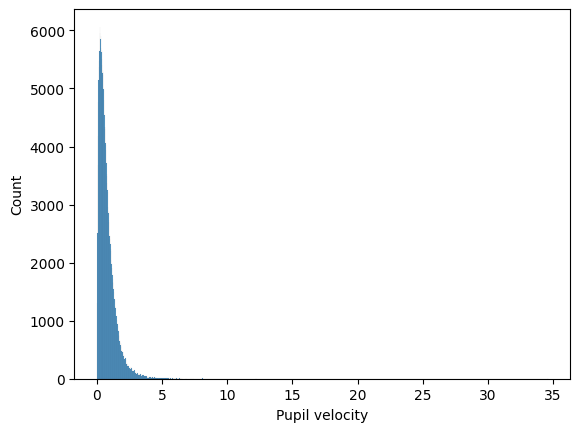

In [9]:
sns.histplot(data=data_df, x="Pupil velocity")

In [10]:
def plot_trial_speed_MAD(data_df, trial_no):
    plt.figure(figsize=(30, 10))

    plt.plot(
        data_df["Trial time Sec"][data_df["Trial no"] == trial_no],
        data_df["Pupil velocity"][data_df["Trial no"] == trial_no],
        label="speed mm/s",
        marker=".",
        linestyle="none",
    )
    plt.plot(
        data_df["Trial time Sec"][data_df["Trial no"] == trial_no],
        data_df["Stim eye - Size Mm"][data_df["Trial no"] == trial_no],
        label="size mm",
        marker=".",
        linestyle="none",
    )
    plt.plot(
        data_df["Trial time Sec"][
            (data_df["Trial no"] == trial_no)
            & (data_df["Pupil velocity"] > data_df["MAD speed threshold"])
        ],
        data_df["Stim eye - Size Mm"][
            (data_df["Trial no"] == trial_no)
            & (data_df["Pupil velocity"] > data_df["MAD speed threshold"])
        ],
        marker=".",
        linestyle="none",
        color="k",
        label="Removed by MAD",
    )
    plt.plot(
        data_df["Trial time Sec"][data_df["Trial no"] == trial_no],
        data_df["MAD speed threshold"][data_df["Trial no"] == trial_no],
        label="mad threshold speed mm",
    )

    plt.ylim([0, 10])
    plt.grid(which="both")
    plt.minorticks_on()
    plt.legend()
    plt.xlabel("Time [s]")
    plt.show()

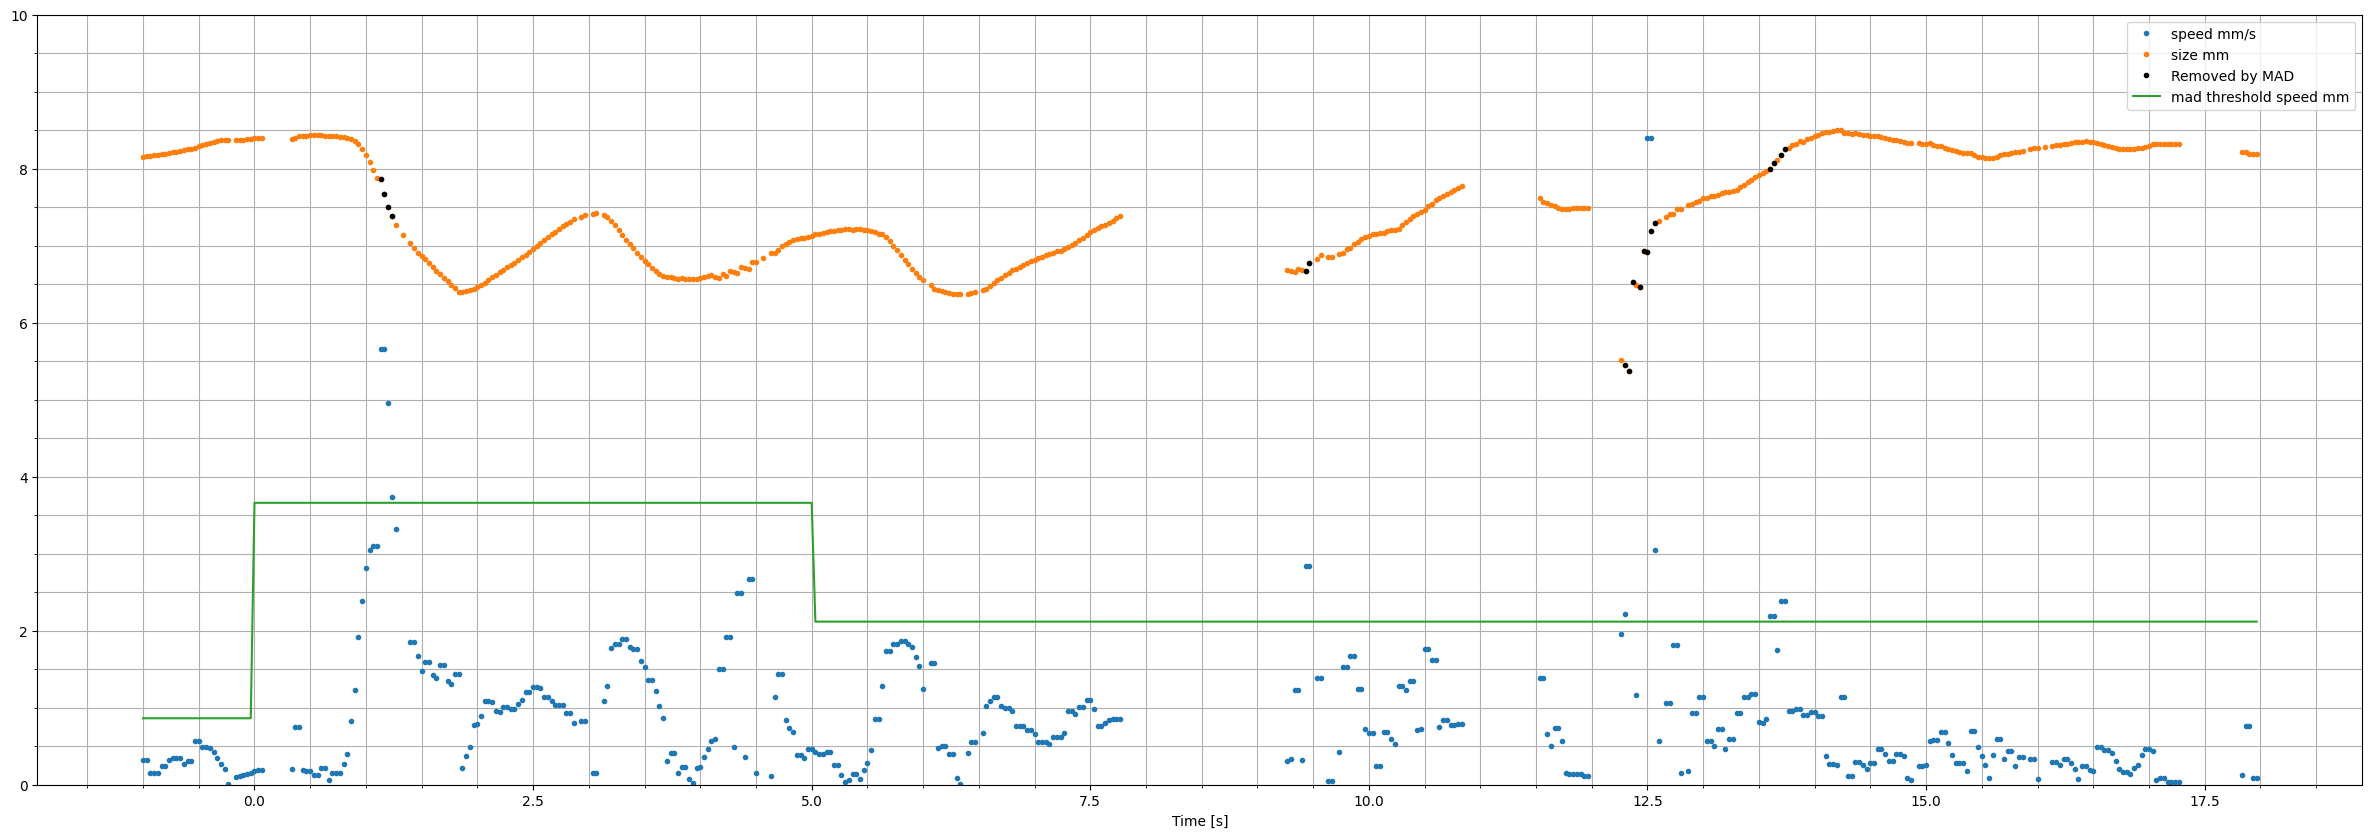

In [11]:
plot_trial_speed_MAD(data_df, 185)

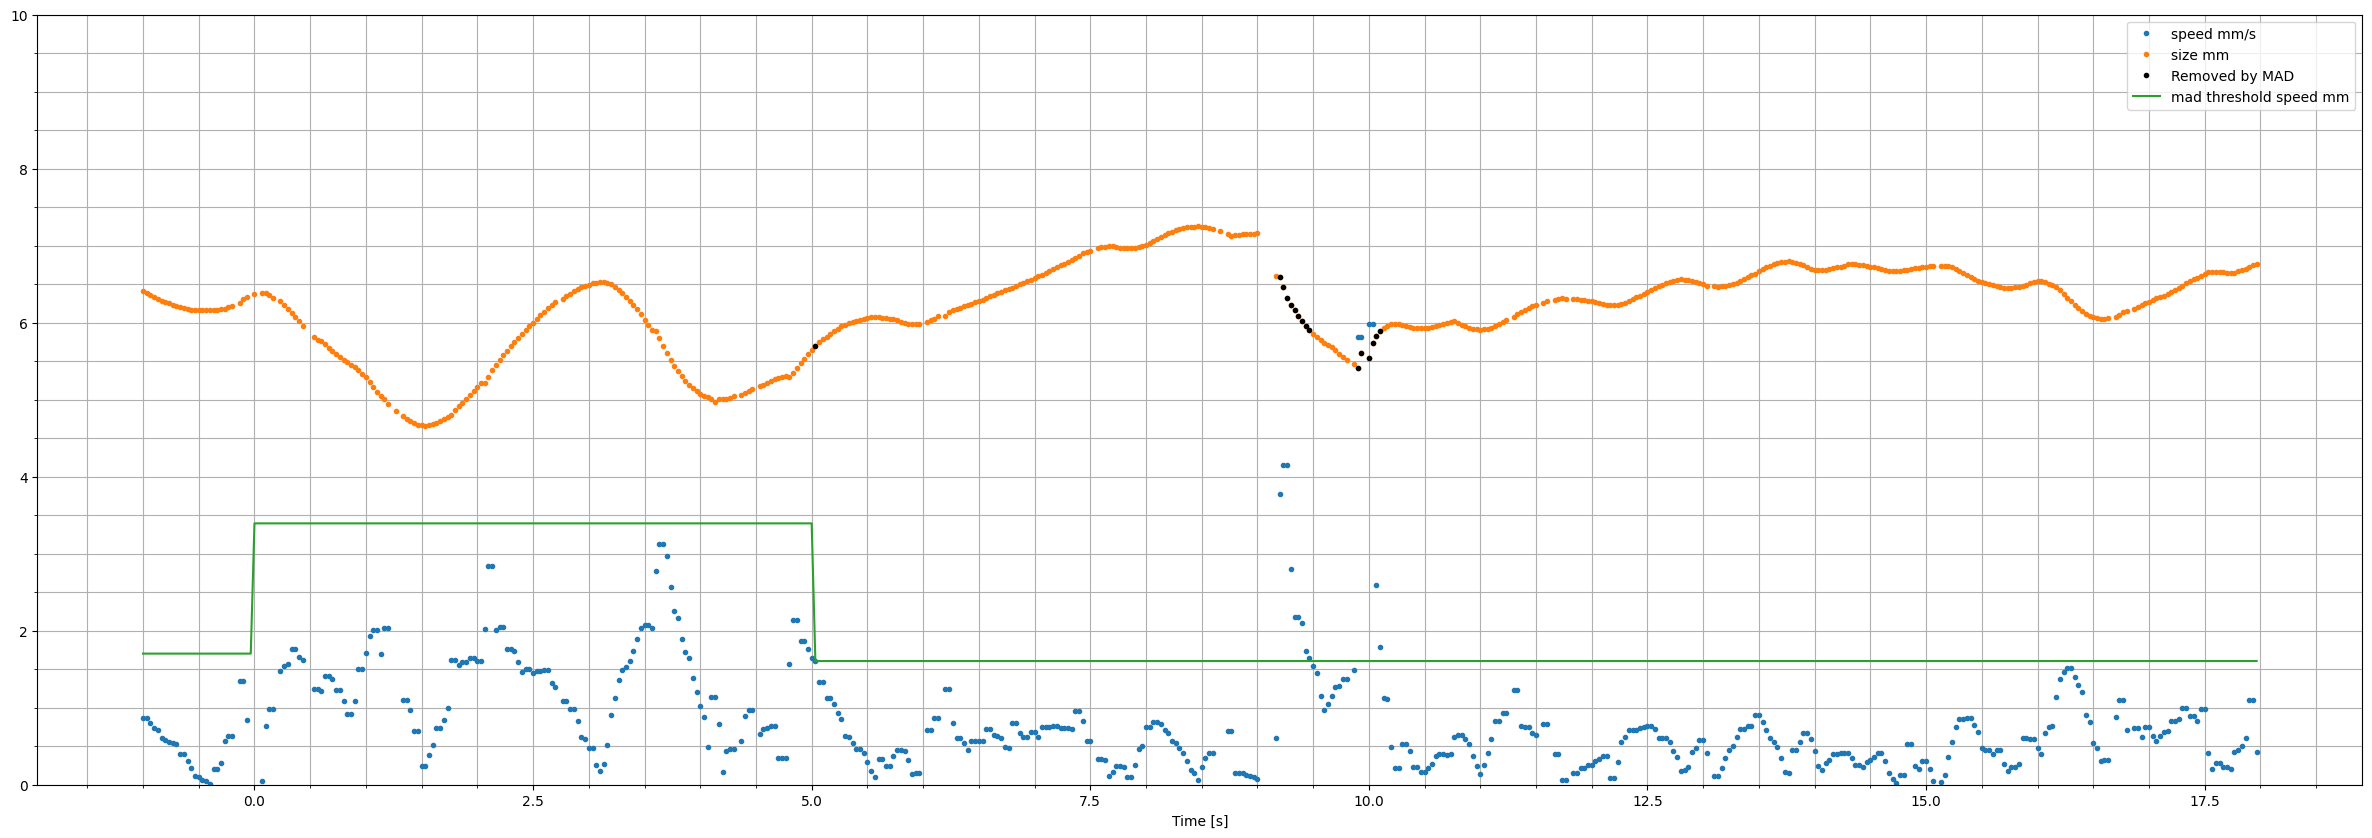

In [12]:
plot_trial_speed_MAD(data_df, 120)

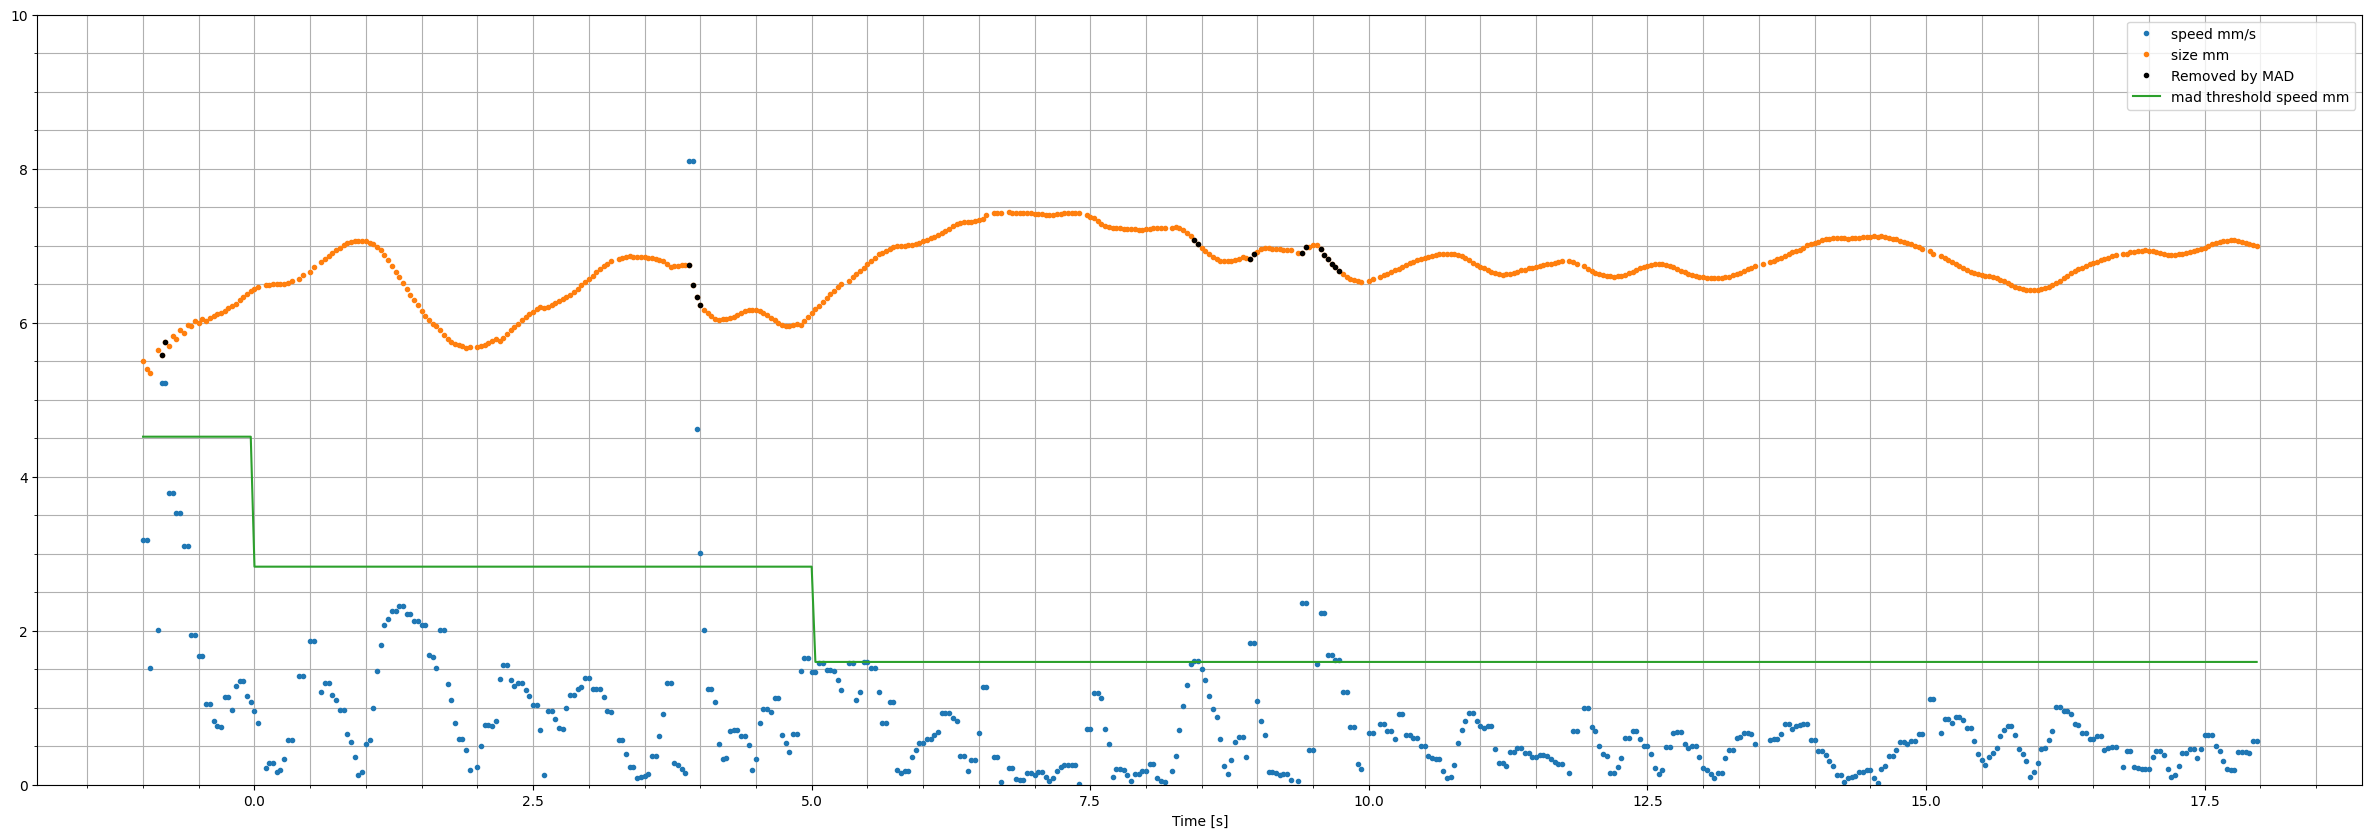

In [13]:
plot_trial_speed_MAD(data_df, 20)

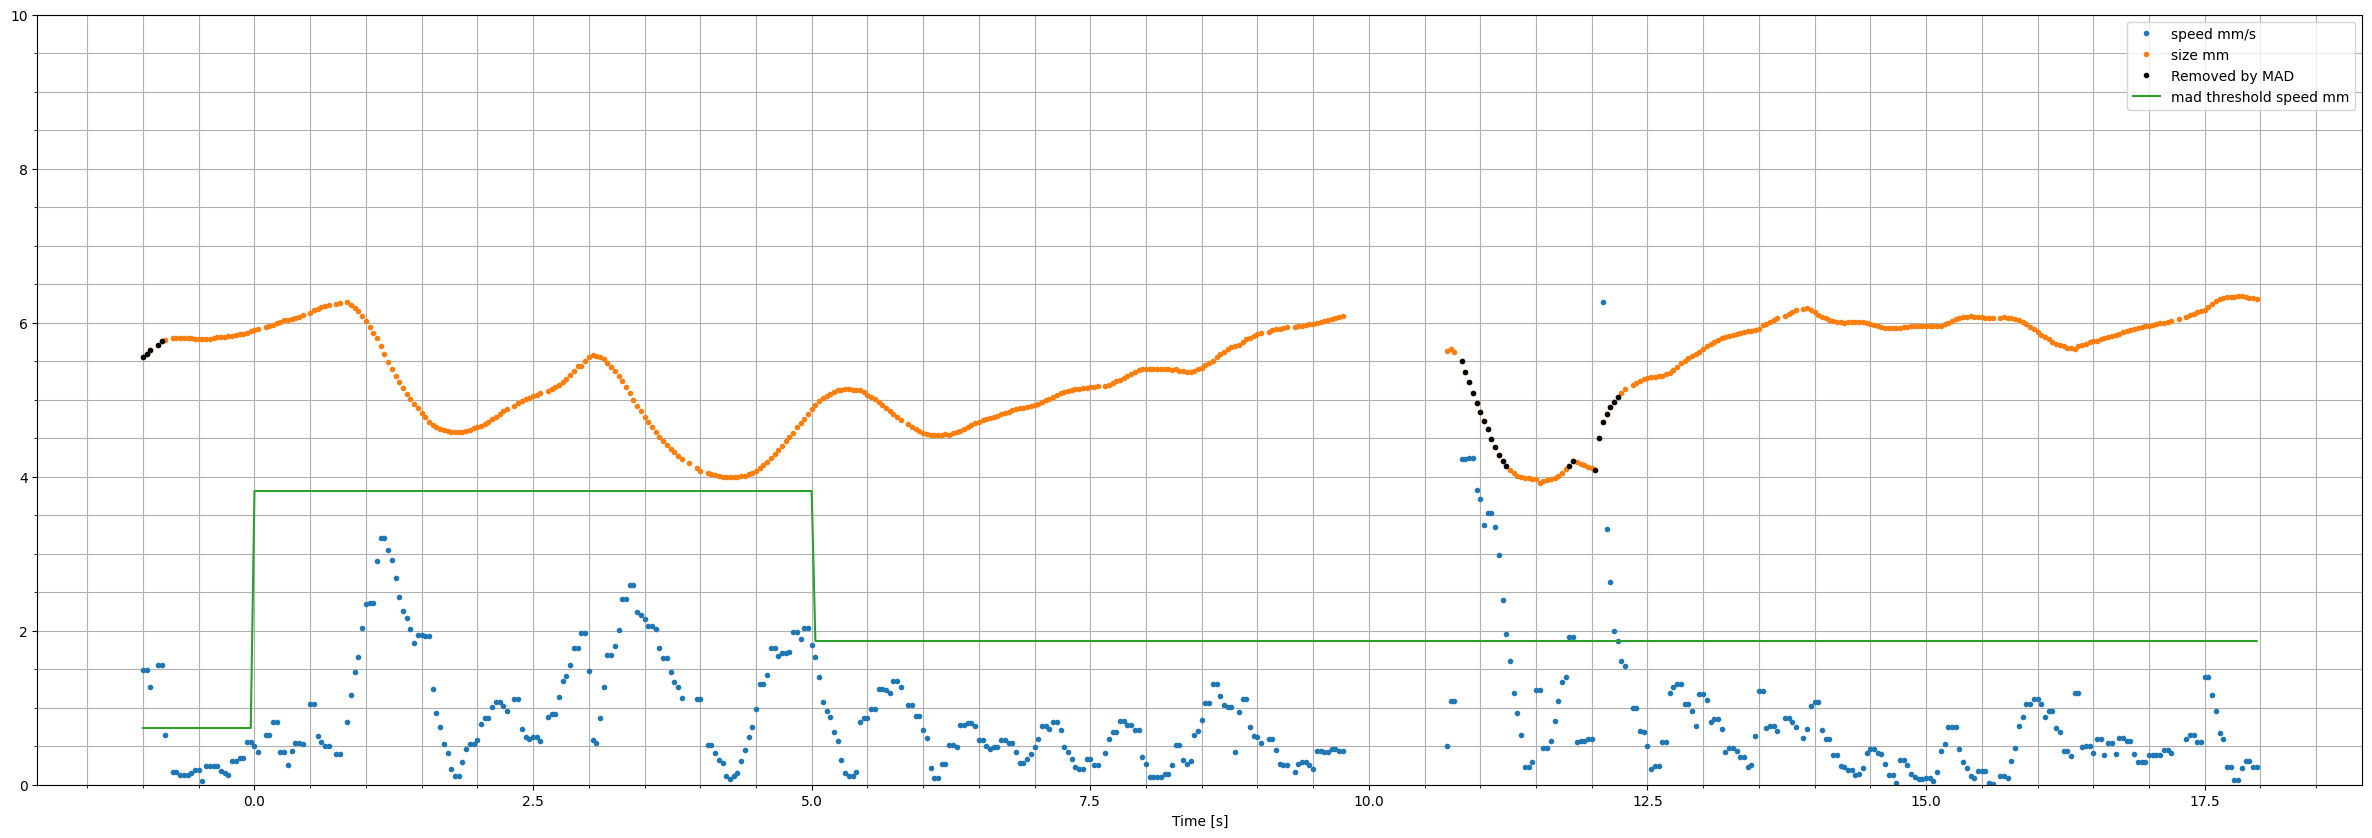

In [14]:
plot_trial_speed_MAD(data_df, 435)

As seen in the examples above, the MAD threshold is calculated for each trial phase separately. One problematic area for it is the baseline, where due to a low number of samples, potentially a spike can overtake the whole length of the signal and periods where the pupil suddenly constricts/dilates, which causes erroneous deletion of series of samples which may be a part of the wanted signal, e.g. in plot 4, at around 11 seconds. My next proposed step is filtering based on pupil size, which ought to remove the few flatter spike points, like e.g. can be seen in the first plot for trial 185. 

## <a id='toc3_2_'></a>[MAD phase-based pupil size filtering](#toc0_)

In literature, samples are often marked as artifacts/outliers based on z-score - so measure of distance in standard deviations from the mean. However, I decided to implement MAD instead since this method is not making assumptions about data distribution.

First I try to compute MAD for phases of the trial like I did with the speed-based outlier rejection: baseline, stimulus phase, post-stimulus phase. For pupil size, I calculate two thresholds, upper = median+multiplier x MAD and lower=median-multiplier x MAD. This is because for velocity, the artifacts were only present in the form of absolute velocity exceeding a threshold. However for size, artefacts can present as both too small and too large measurements. The concerns are such that we don't want to remove too many samples, since data already has fairly large gaps, but we want to remove those that e.g. were not characterized by velocity (for instance two samples at low velocity that are surrounded by gaps and are much lower than the rest of data in the time period).

I again chose a multiplier in the upper ranges, 4.5, so that we don't remove too many real samples.

In [ ]:
def compute_phase_pupil_size_mad(resampled_df, multiplier=4.5):

    for trial_no in sorted(resampled_df["Trial no"].unique()):
        trial = resampled_df[resampled_df["Trial no"] == trial_no].copy()

        for phase in sorted(trial["Trial phase"].unique()):

            median = trial["Stim eye - Size Mm"][trial["Trial phase"] == phase].median()
            mad = (
                abs(trial["Stim eye - Size Mm"][trial["Trial phase"] == phase] - median)
            ).median()
            threshold_up = median + multiplier * mad
            threshold_down = median - multiplier * mad

            resampled_df.loc[
                (resampled_df["Trial no"] == trial_no)
                & (resampled_df["Trial phase"] == phase),
                "MAD size upper threshold",
            ] = threshold_up
            resampled_df.loc[
                (resampled_df["Trial no"] == trial_no)
                & (resampled_df["Trial phase"] == phase),
                "MAD size lower threshold",
            ] = threshold_down

    return resampled_df

In [16]:
def plot_trial_size_MAD(data_df, trial_no):
    plt.figure(figsize=(30, 10))

    plt.plot(
        data_df["Trial time Sec"][data_df["Trial no"] == trial_no],
        data_df["Stim eye - Size Mm"][data_df["Trial no"] == trial_no],
        label="size mm",
        marker=".",
        linestyle="none",
    )
    plt.plot(
        data_df["Trial time Sec"][
            (data_df["Trial no"] == trial_no)
            & (data_df["Stim eye - Size Mm"] > data_df["MAD size upper threshold"])
        ],
        data_df["Stim eye - Size Mm"][
            (data_df["Trial no"] == trial_no)
            & (data_df["Stim eye - Size Mm"] > data_df["MAD size upper threshold"])
        ],
        marker=".",
        linestyle="none",
        color="k",
        label="Removed by MAD",
    )
    plt.plot(
        data_df["Trial time Sec"][
            (data_df["Trial no"] == trial_no)
            & (data_df["Stim eye - Size Mm"] < data_df["MAD size lower threshold"])
        ],
        data_df["Stim eye - Size Mm"][
            (data_df["Trial no"] == trial_no)
            & (data_df["Stim eye - Size Mm"] < data_df["MAD size lower threshold"])
        ],
        marker=".",
        linestyle="none",
        color="k",
        label="Removed by MAD",
    )
    plt.plot(
        data_df["Trial time Sec"][data_df["Trial no"] == trial_no],
        data_df["MAD size upper threshold"][data_df["Trial no"] == trial_no],
        label="mad threshold size up mm",
    )
    plt.plot(
        data_df["Trial time Sec"][data_df["Trial no"] == trial_no],
        data_df["MAD size lower threshold"][data_df["Trial no"] == trial_no],
        label="mad threshold size low mm",
    )

    plt.ylim([0, 10])
    plt.grid(which="both")
    plt.minorticks_on()
    plt.legend()
    plt.xlabel("Time [s]")
    plt.show()

In [17]:
data_df = remove_samples_above_speed_MAD(data_df, multiplier=4.5)

In [18]:
data_df = compute_phase_pupil_size_mad(data_df, multiplier=4.5)

c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\larea\OneDrive\Dokumenty\CiViBe\civibe_tscn_repo\civibe_pupilprep\.venv\lib\site-packages\numpy

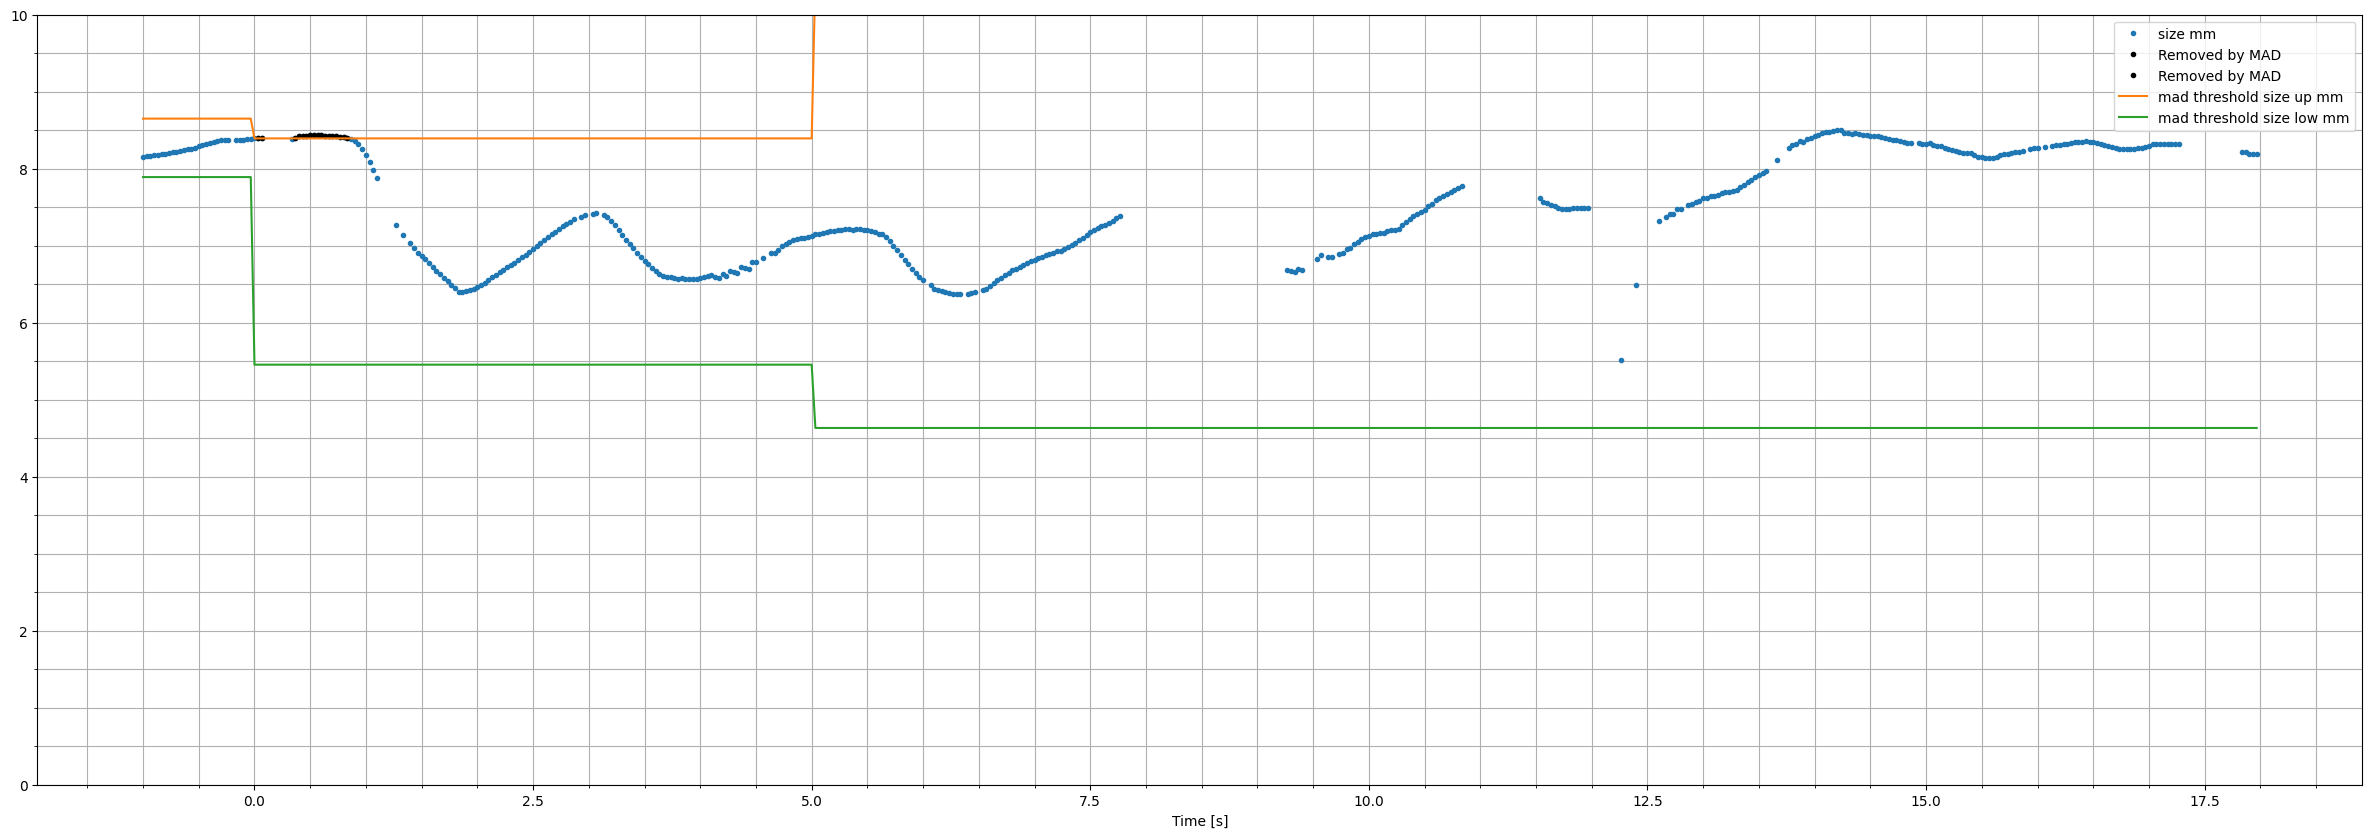

In [19]:
plot_trial_size_MAD(data_df, 185)

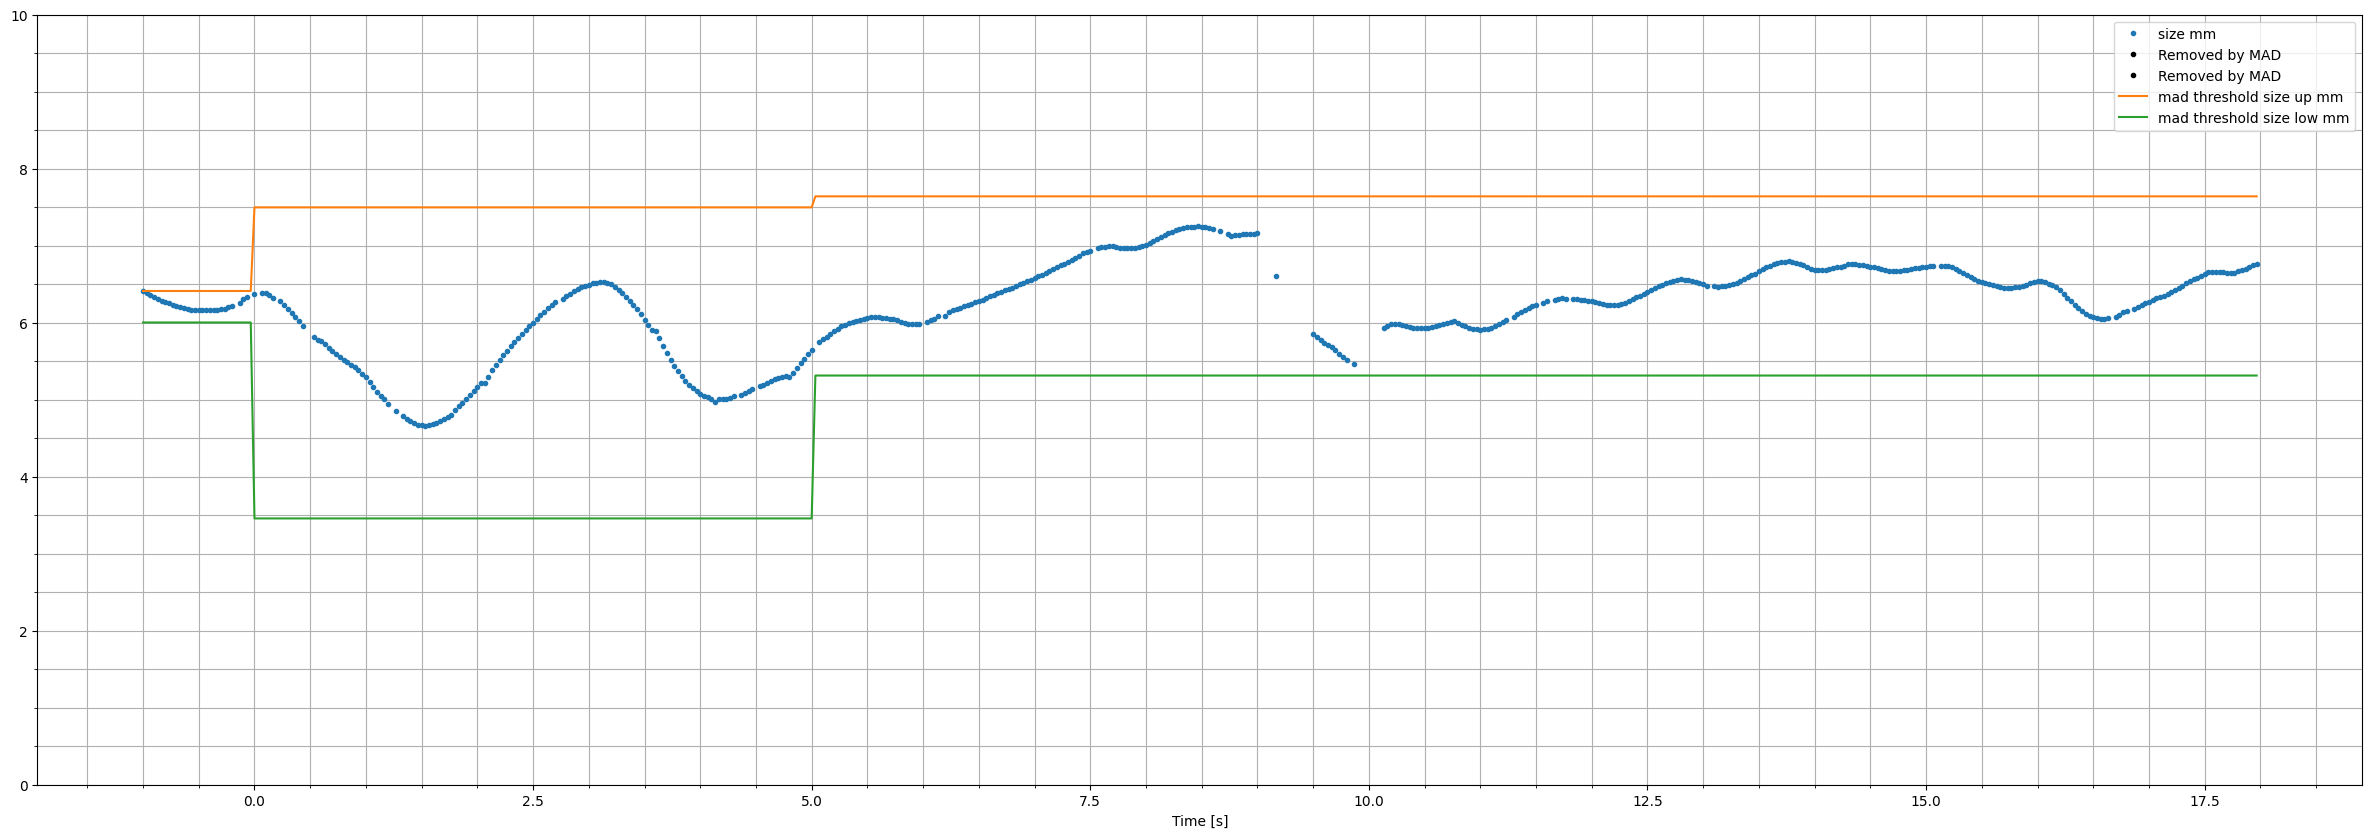

In [20]:
plot_trial_size_MAD(data_df, 120)

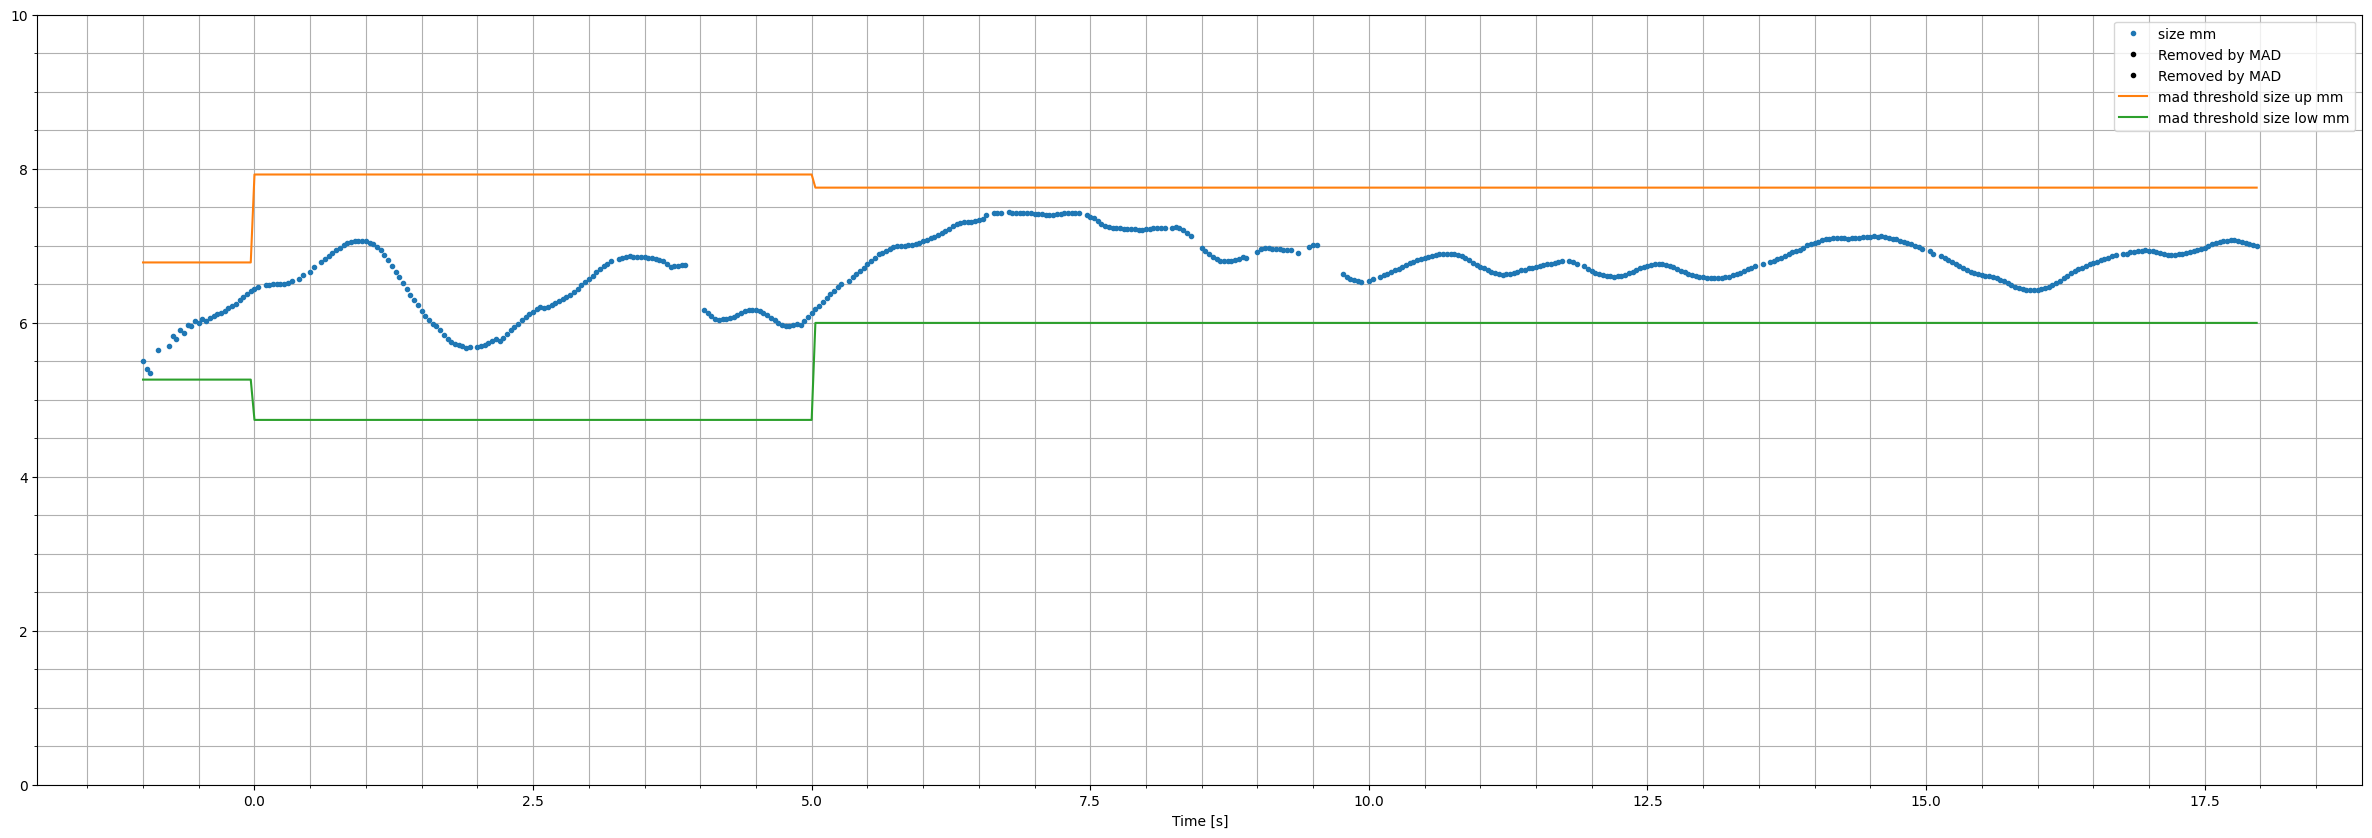

In [21]:
plot_trial_size_MAD(data_df, 20)

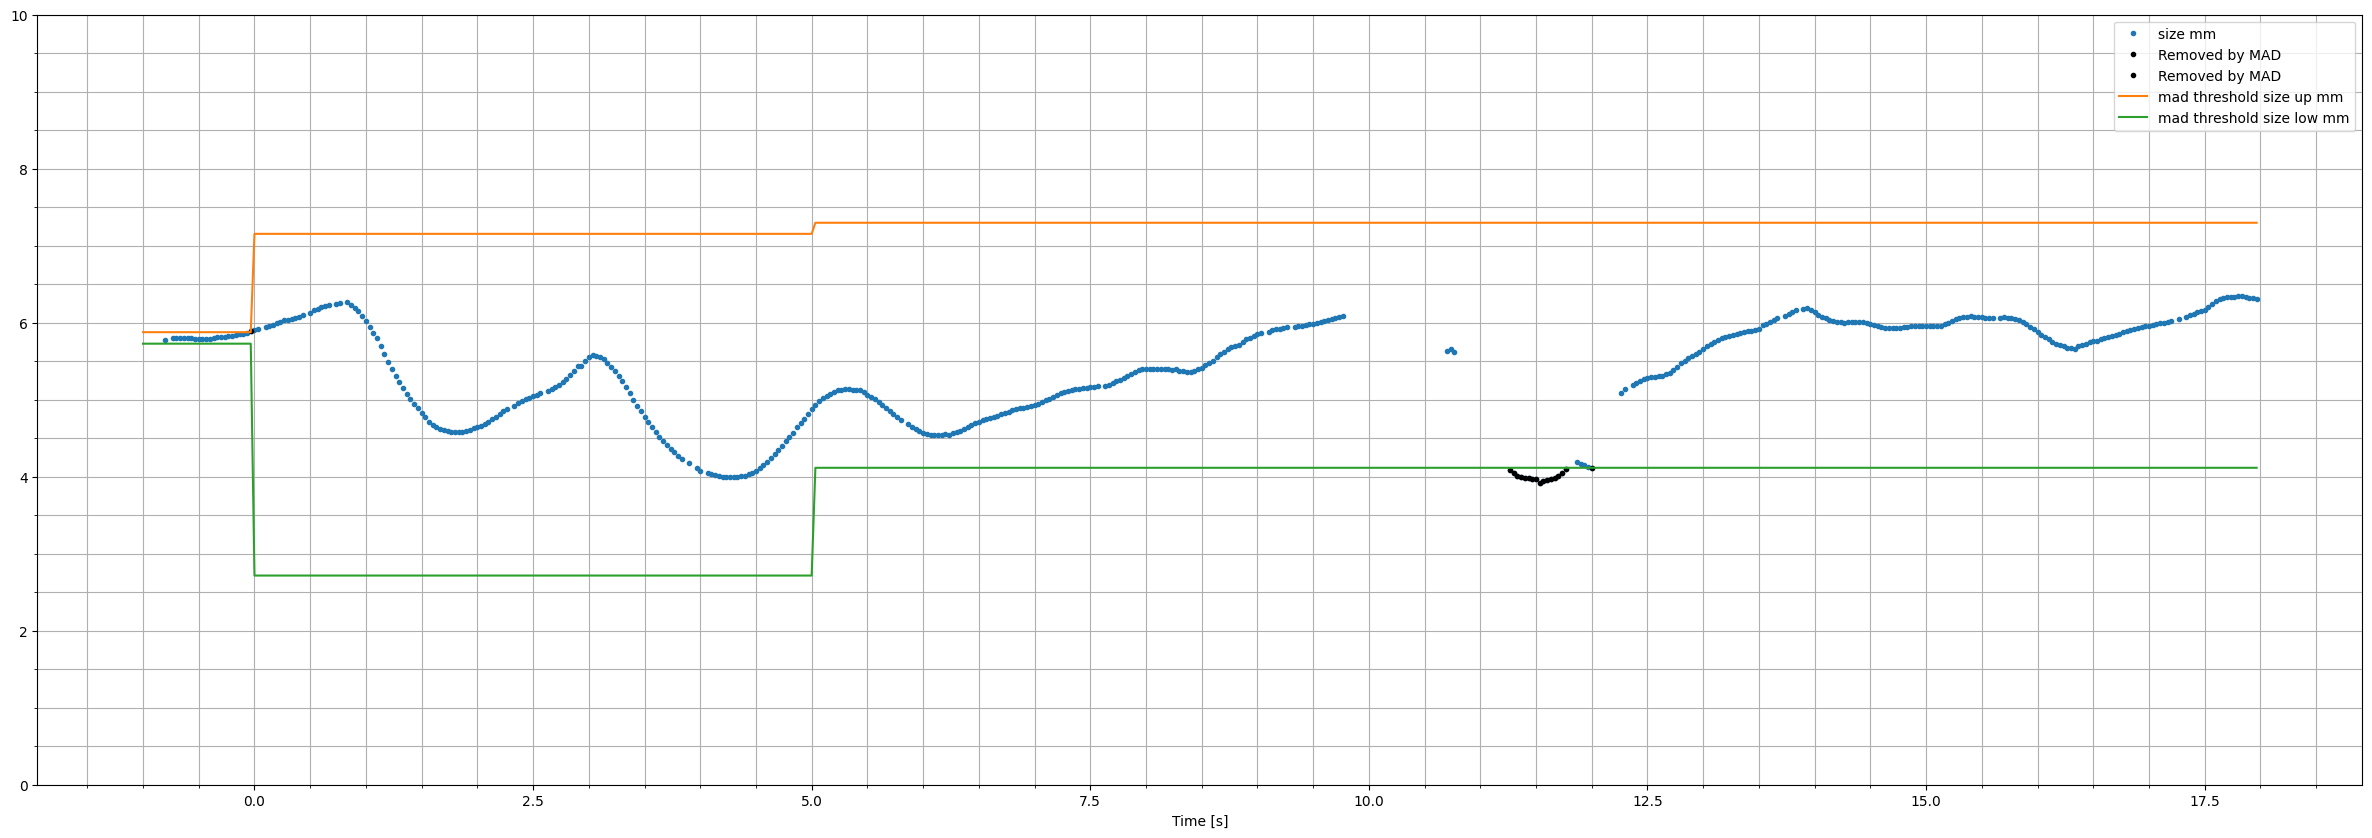

In [22]:
plot_trial_size_MAD(data_df, 435)

It can be seen in the plots that the phase-based MAD calculation is not fulfilling its purpose well enough - especially in the stimulus phase e.g. in the first plot it removes the plateau period before pupil response onset but it leaves the singular points from the spike we identified around 12 s. 

## <a id='toc3_3_'></a>[Conclusions](#toc0_)

I don't believe a phase-based approach is precise enough to ensure maximum data retention. Therefore, I propose the rolling window approach, which looks at a signal more locally in smaller windows.

# <a id='toc4_'></a>[MAD rolling window outlier detection](#toc0_)

The approach of using a rolling window iterates over the signal with a window of size x, and an overlap of x-1. It calculates the MAD and MAD threshold value within that window, and sets it as the centre point of the window. This way we obtain local measures for the signal, so we preserve local changes which is important in the case of the pupil constriction and dilation.

One issue for windowed methods is selection of window size. Sources recommend 10-25% of signal length, which in our case, considering segmenting by trial of length ~550, amounts to between about 55 - 120 samples. There's also the recommendation to base it on properties of the signal, i.e. what is the width/shape of outliers we want to remove. The sources of artifacts that lead to outlier pupil size are blinks, partial eye closing, failure of the device. Blinks last from 100 to 400 ms, to capture the artifacts around the blinks we need a window size that is larger than this period - especially since a large part of a blink is empty, leading to NaN values in that region. For the other artifact sources, we have no specific knowledge that can inform the window size. As a starting point for testing, I choose a window of 60 samples = 2 seconds and a multiplier of 4.5 for MAD threshold. 

## <a id='toc4_1_'></a>[Rolling window MAD for pupil velocity](#toc0_)

The MAD is calculated as in the section above, with the difference that now it's calculated in each window instead of each phase.

In [23]:
def compute_rolling_pupil_speed_mad(resampled_df, step=60, multiplier=4.5):
    resampled_df["Pupil velocity"] = pd.Series()
    resampled_df["MAD speed threshold"] = pd.Series()
    resampled_df["Time diff"] = resampled_df["Trial time Sec"].diff()
    resampled_df["Size diff"] = resampled_df["Stim eye - Size Mm"].diff()
    resampled_df.loc[resampled_df["Time diff"] < 0, "Size diff"] = pd.NA
    resampled_df.loc[resampled_df["Time diff"] < 0, "Time diff"] = pd.NA

    for trial_no in sorted(resampled_df["Trial no"].unique()):
        trial = resampled_df[resampled_df["Trial no"] == trial_no].copy()
        trial["Pupil velocity -1"] = abs(trial["Size diff"] / trial["Time diff"])
        trial["Pupil velocity +1"] = abs(
            trial["Size diff"].shift(-1) / trial["Time diff"].shift(-1)
        )
        trial["Pupil velocity"] = trial[["Pupil velocity -1", "Pupil velocity +1"]].max(
            axis="columns"
        )

        median = (
            trial["Pupil velocity"]
            .rolling(window=step, min_periods=1, center=True)
            .median()
        )

        mad = (
            trial["Pupil velocity"]
            .rolling(window=step, min_periods=1, center=True)
            .apply(lambda x: np.nanmedian(np.abs(x - np.nanmedian(x))), raw=True)
        )

        trial.loc[:, "MAD speed threshold"] = median + multiplier * mad
        resampled_df.loc[
            resampled_df["Trial no"] == trial_no, "MAD speed threshold"
        ] = trial["MAD speed threshold"]
        resampled_df.loc[resampled_df["Trial no"] == trial_no, "Pupil velocity"] = (
            trial["Pupil velocity"]
        )

    return resampled_df

In [24]:
data_dir = "./results/resampled/"  # directory with resampled data
data_suffix = "_nonan_30_resampled_data.csv"  # name of file with 30 Hz resampled data from participant 2xx, name format: 2xxdata_suffix

data_path = os.path.join(data_dir, str(201) + data_suffix)
data_df = pd.read_csv(data_path)

In [26]:
data_df = remove_non_physio_size(data_df)
data_df = compute_rolling_pupil_speed_mad(data_df)

In [27]:
percent_to_remove = (
    100
    * len(data_df[(data_df["Pupil velocity"] > data_df["MAD speed threshold"])])
    / len(data_df)
)
print(f"Percentage of samples above threshold: {percent_to_remove}")

Percentage of samples above threshold: 2.9577276524644946


As expected, percentage of samples to remove is lower in the rolling window approach.

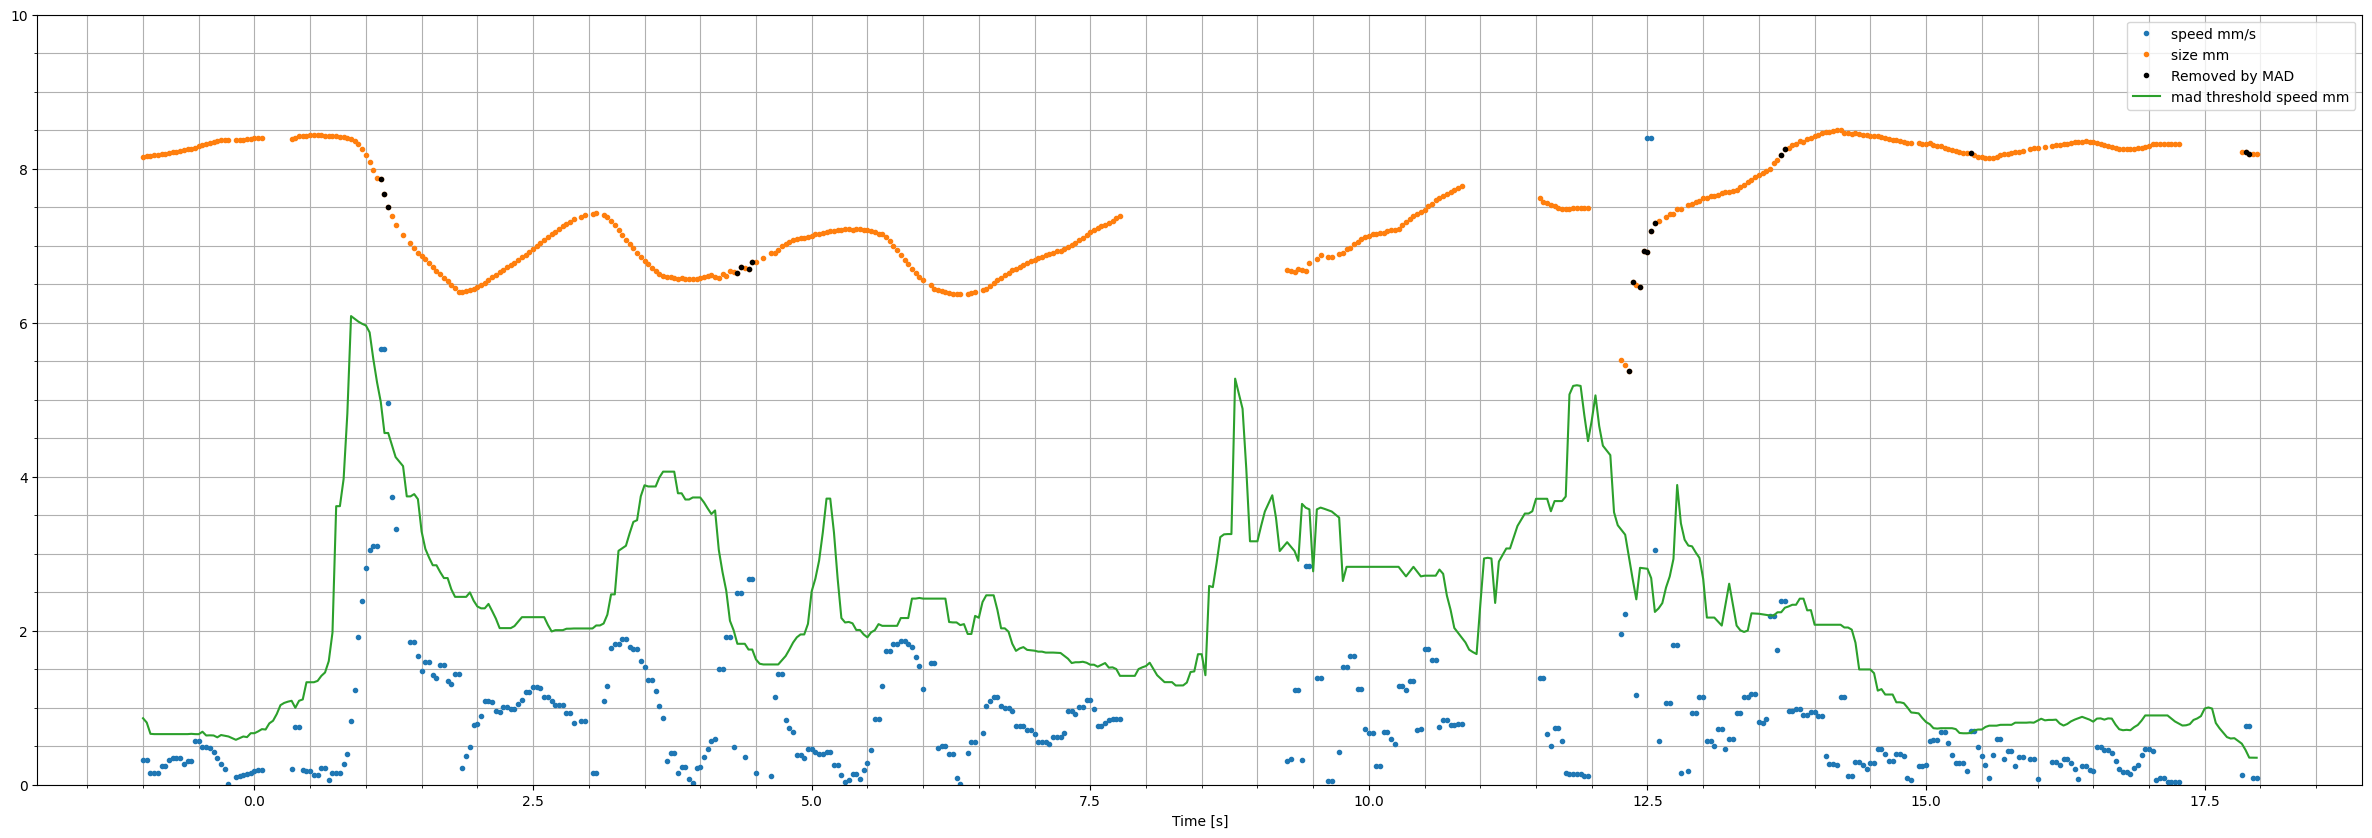

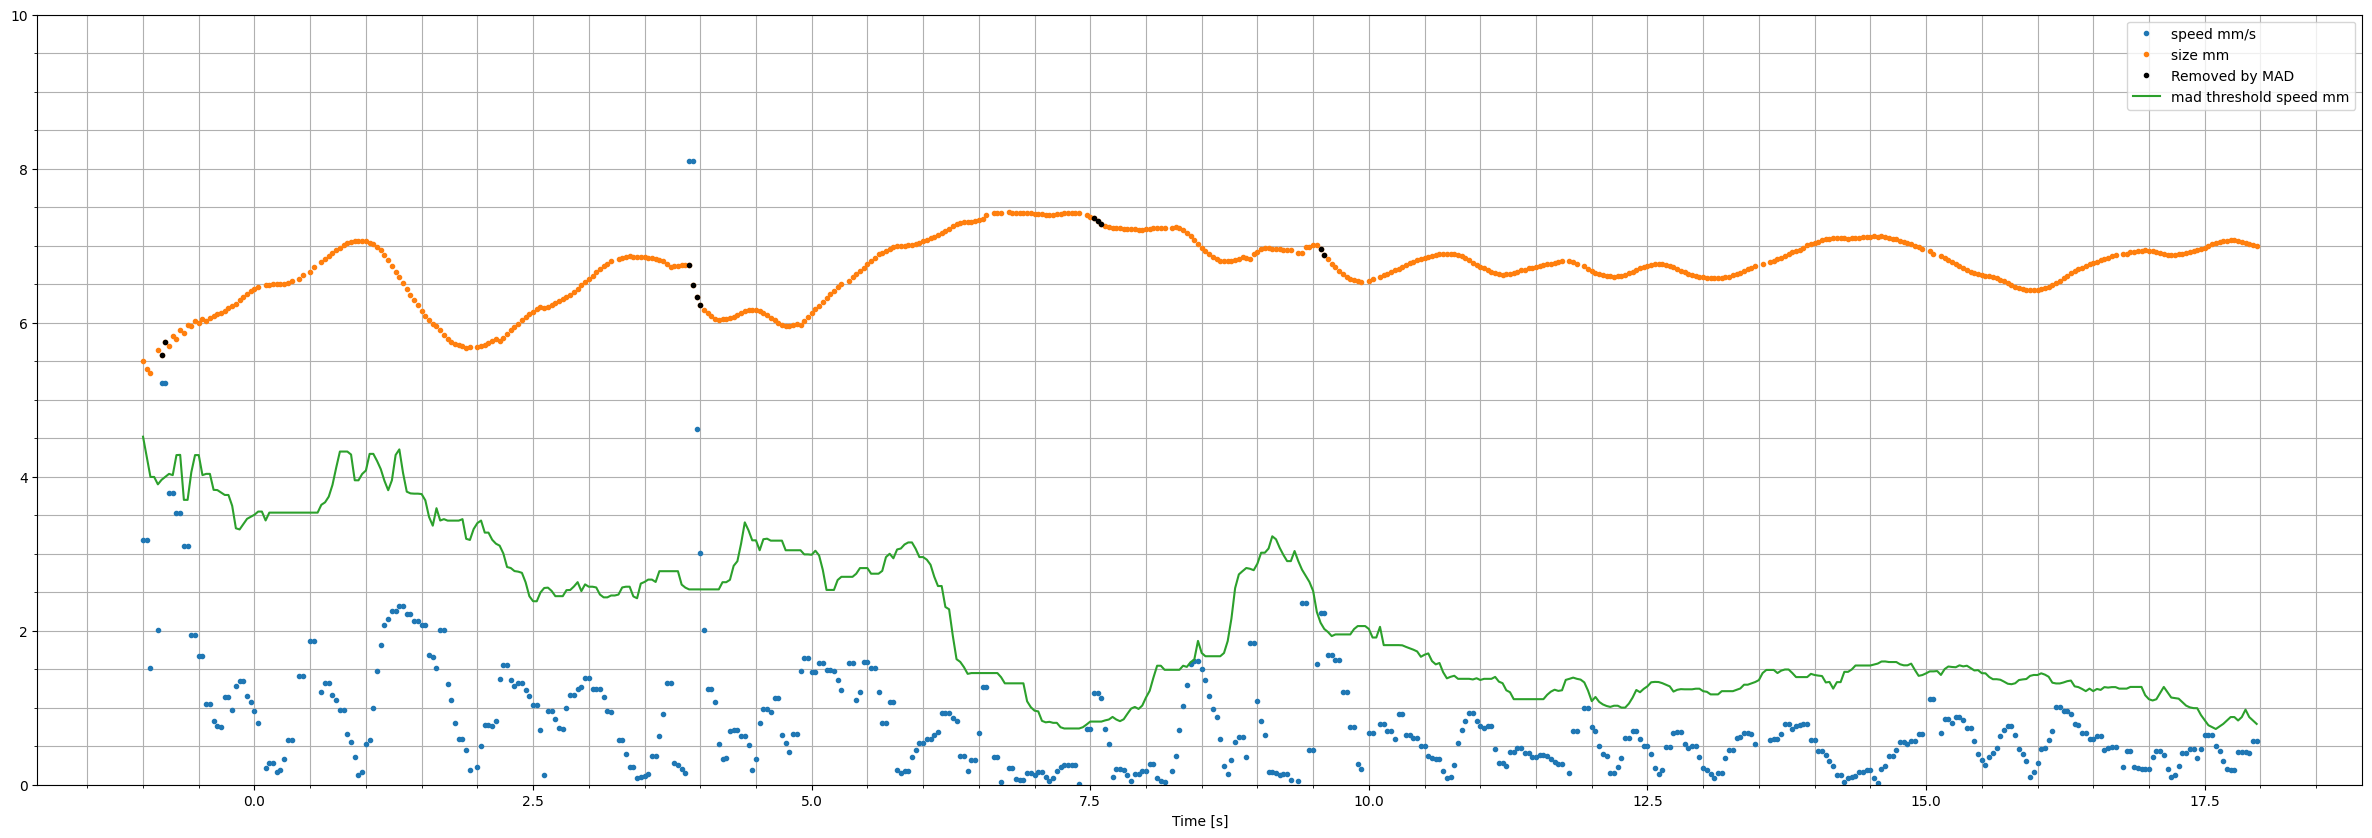

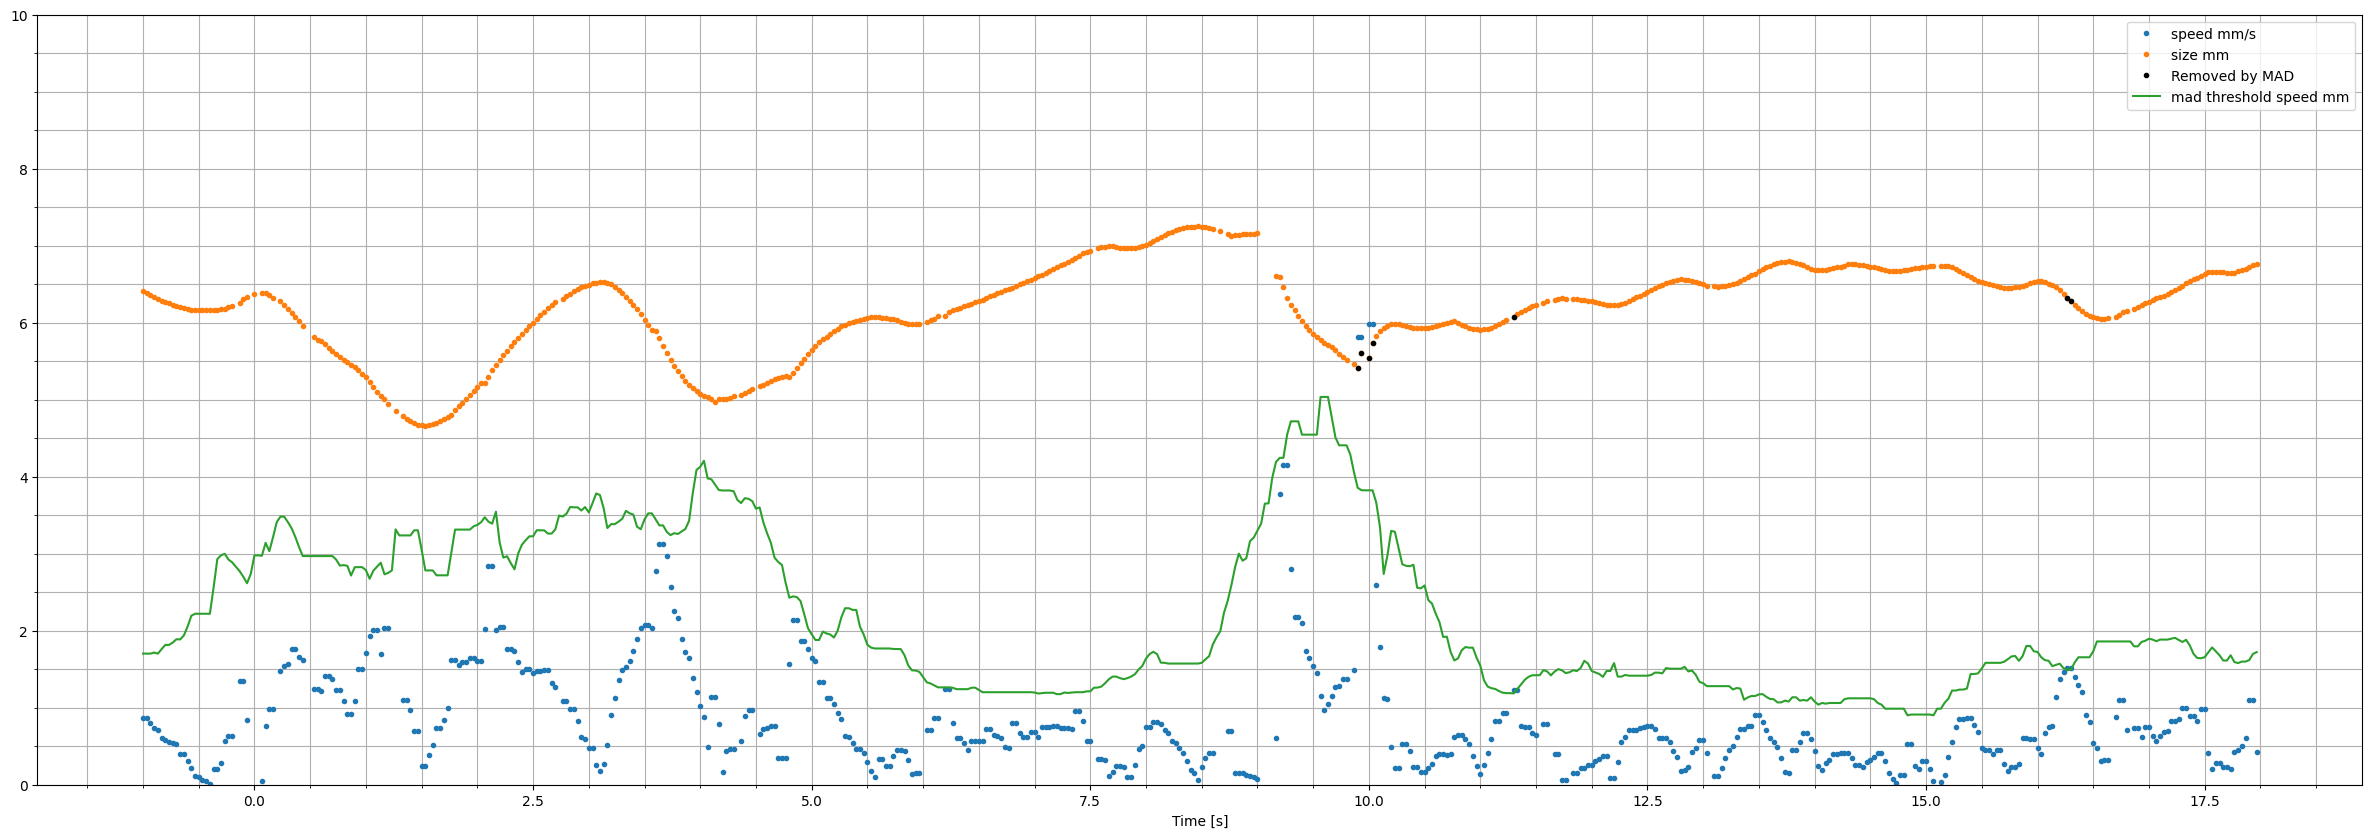

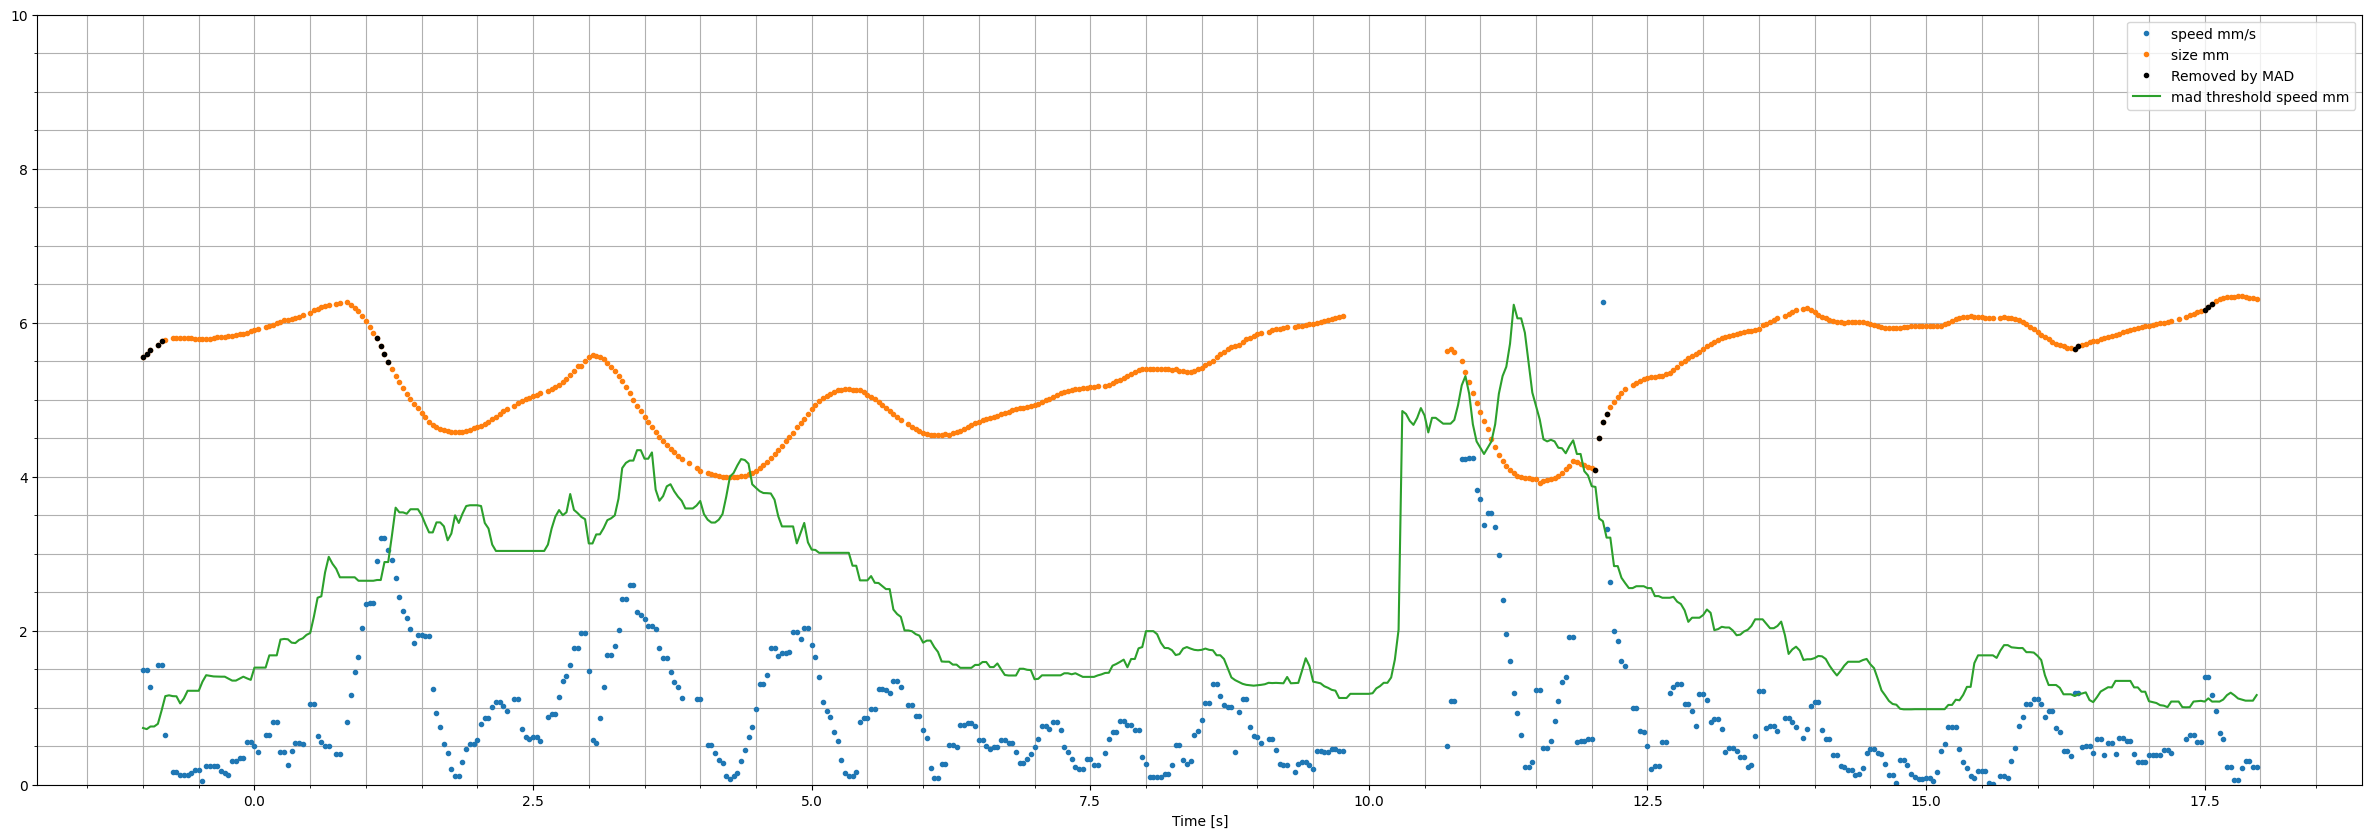

In [29]:
plot_trial_speed_MAD(data_df, 185)
plot_trial_speed_MAD(data_df, 20)
plot_trial_speed_MAD(data_df, 120)
plot_trial_speed_MAD(data_df, 435)

## <a id='toc4_2_'></a>[Rolling window MAD for pupil size](#toc0_)

Motivation: after velocity-based rejection in the rolling approach, there are still size outliers left as well. To ensure precision, I do it with a rolling window again and use the same window size, since it appears to be suitable for this signal.

In [30]:
def compute_rolling_size_mad(resampled_df, step, multiplier):

    resampled_df["MAD size threshold"] = pd.Series()
    for trial_no in sorted(resampled_df["Trial no"].unique()):
        trial = resampled_df[resampled_df["Trial no"] == trial_no].copy(deep=True)
        trial.reset_index(inplace=True)
        trial["MAD size threshold"] = pd.Series()

        median = (
            trial["Stim eye - Size Mm"]
            .rolling(window=step, min_periods=1, center=True)
            .median()
        )

        mad = (
            trial["Stim eye - Size Mm"]
            .rolling(window=step, min_periods=1, center=True)
            .apply(lambda x: np.nanmedian(np.abs(x - np.nanmedian(x))), raw=True)
        )

        trial.loc[:, "MAD size upper threshold"] = median + multiplier * mad
        trial.loc[:, "MAD size lower threshold"] = median - multiplier * mad

        resampled_df.loc[
            resampled_df["Trial no"] == trial_no, "MAD size upper threshold"
        ] = trial["MAD size upper threshold"].to_list()
        resampled_df.loc[
            resampled_df["Trial no"] == trial_no, "MAD size lower threshold"
        ] = trial["MAD size lower threshold"].to_list()

    return resampled_df

In [31]:
data_df = remove_samples_above_speed_MAD(data_df)
data_df = compute_rolling_size_mad(data_df, step=60, multiplier=4.5)

In [38]:
percent_to_remove = (
    100
    * len(
        data_df[
            (data_df["Stim eye - Size Mm"] > data_df["MAD size upper threshold"])
            | (data_df["Stim eye - Size Mm"] < data_df["MAD size lower threshold"])
        ]
    )
    / len(data_df)
)
print(f"Percentage of samples outside threshold: {percent_to_remove}")

Percentage of samples outside threshold: 0.4918964076858814


Size based thresholding seems to remove a very small part of the whole signal, which is desired as the velocity-based thresholding should perform the majority of artefact cleaning.

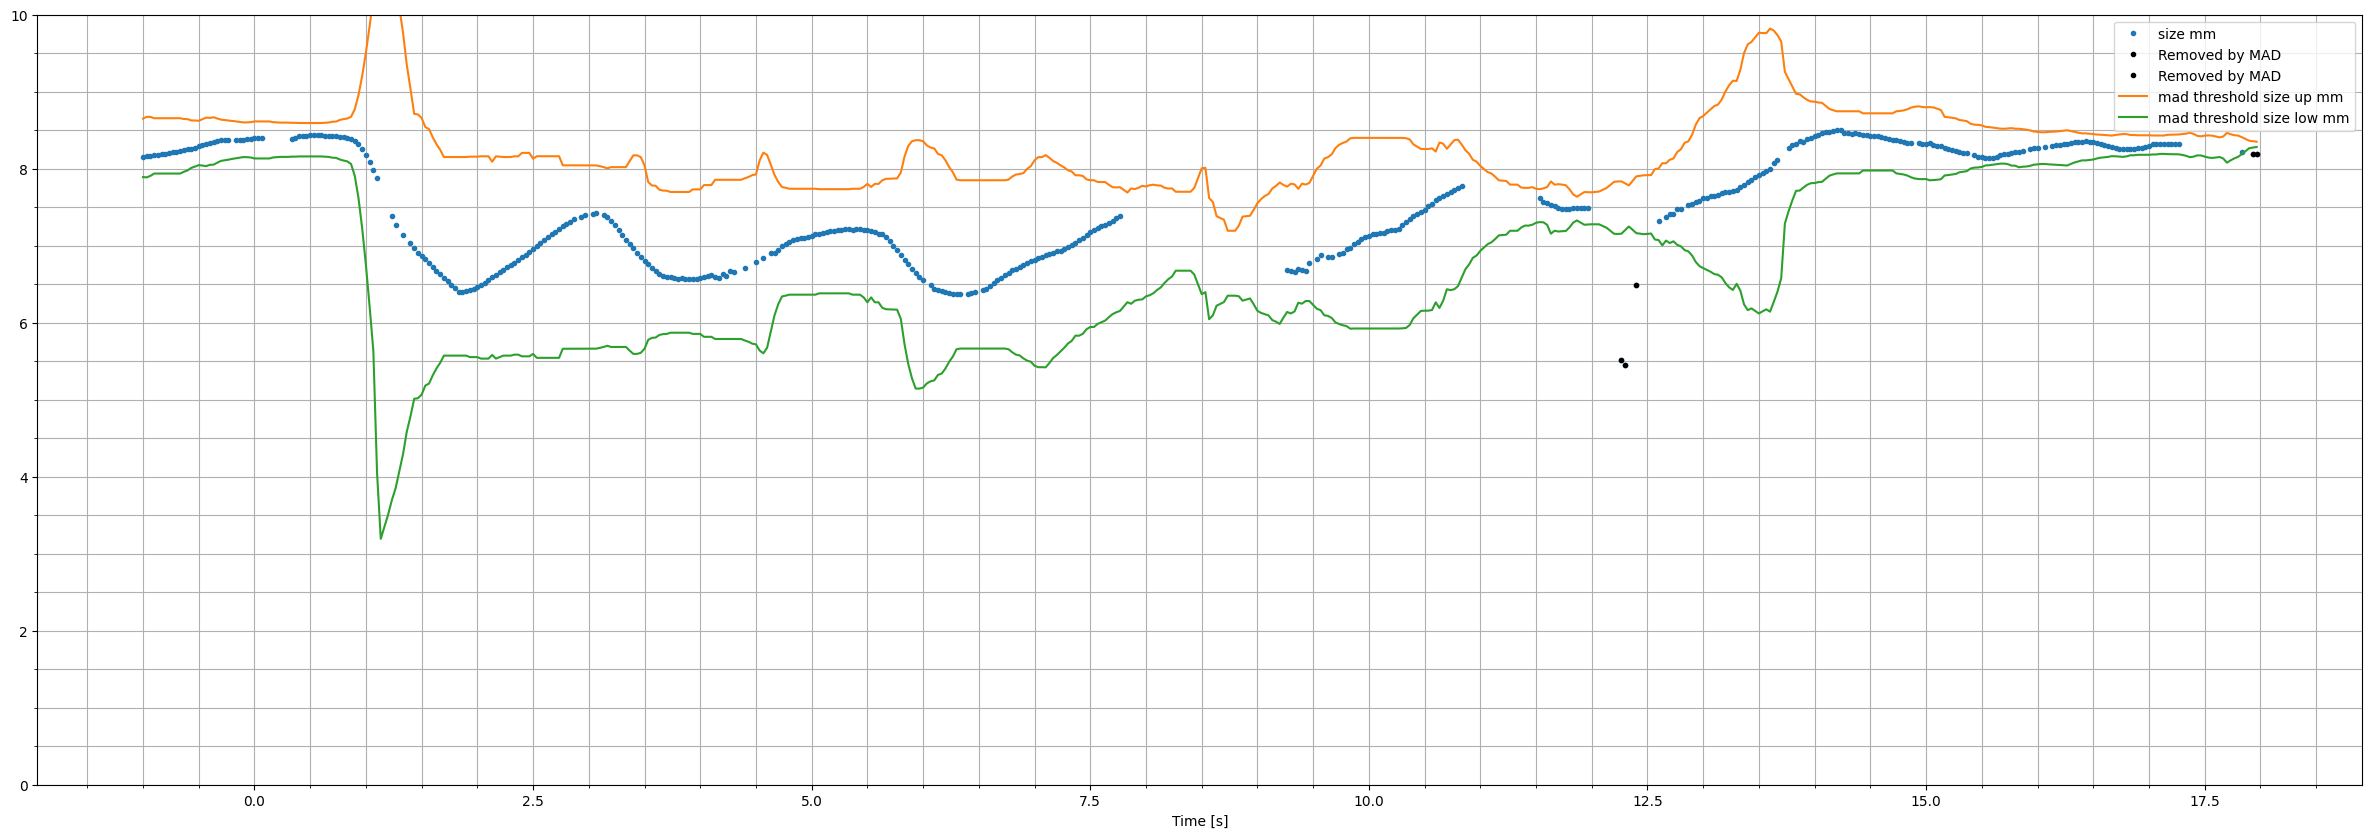

In [33]:
plot_trial_size_MAD(data_df, 185)

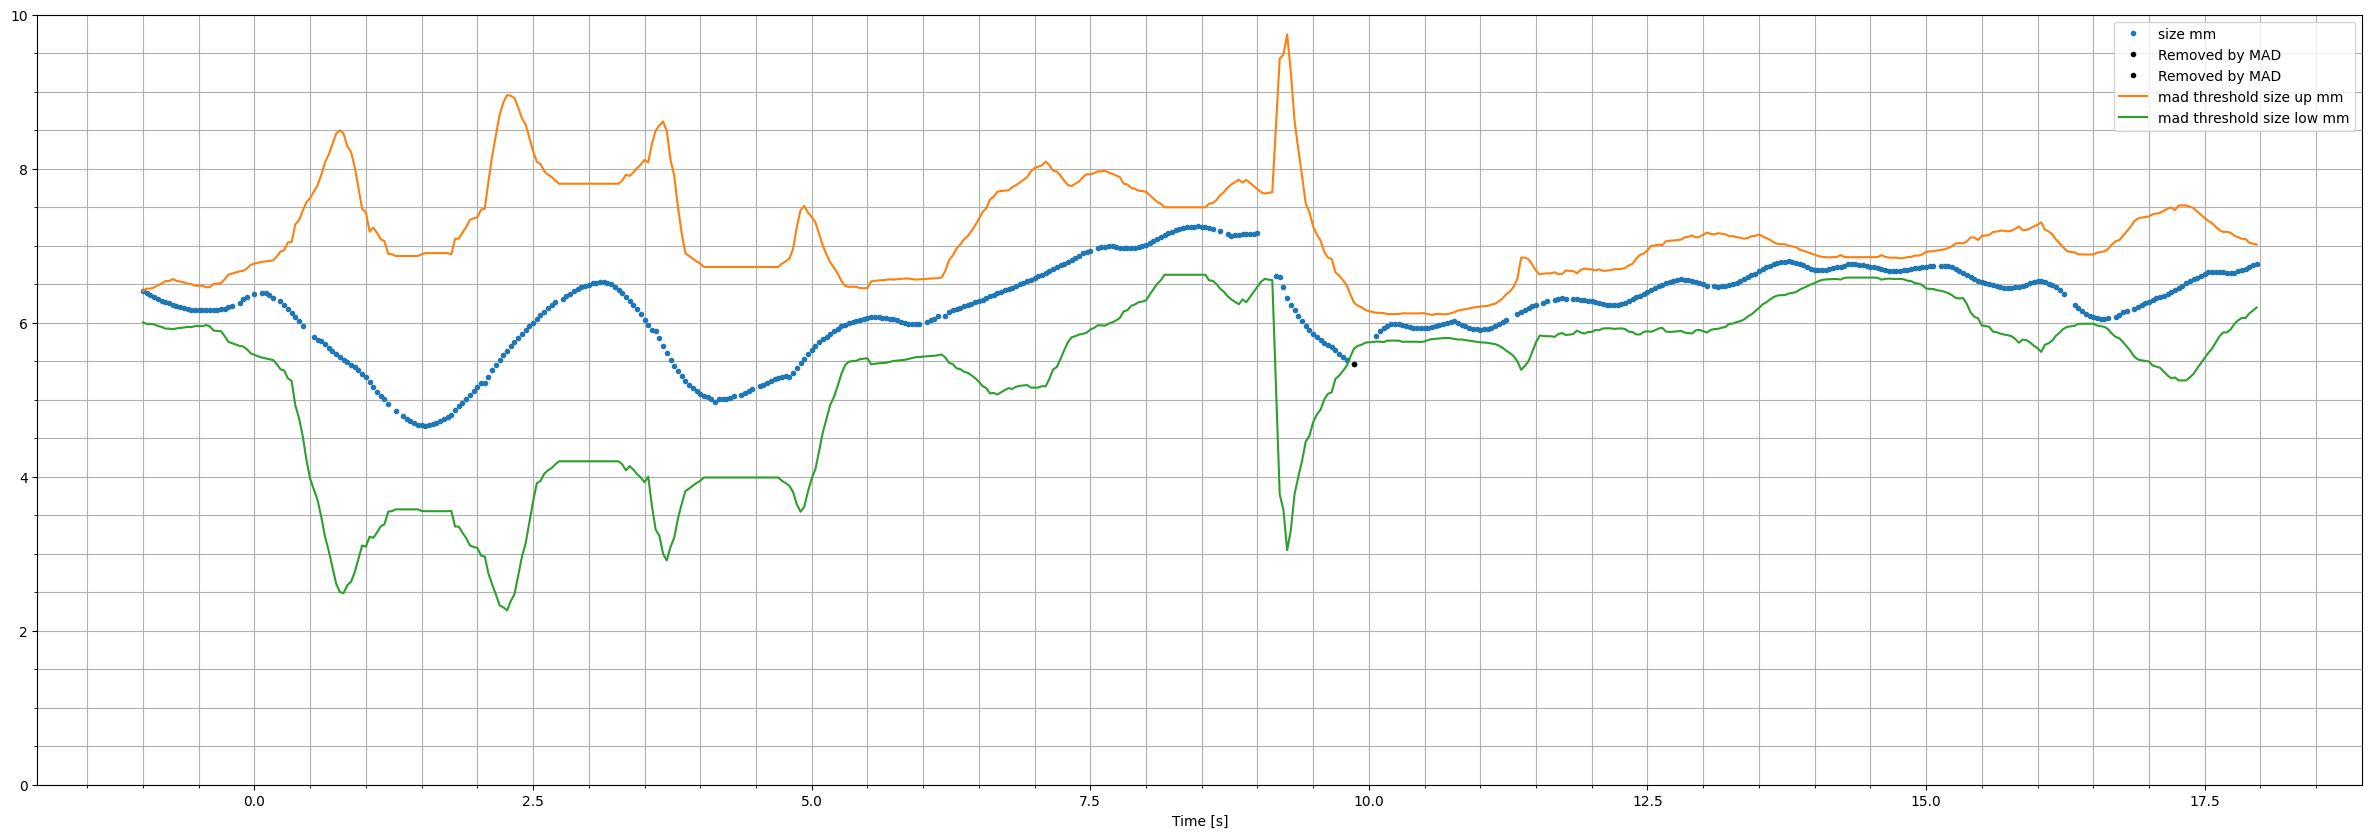

In [34]:
plot_trial_size_MAD(data_df, 120)

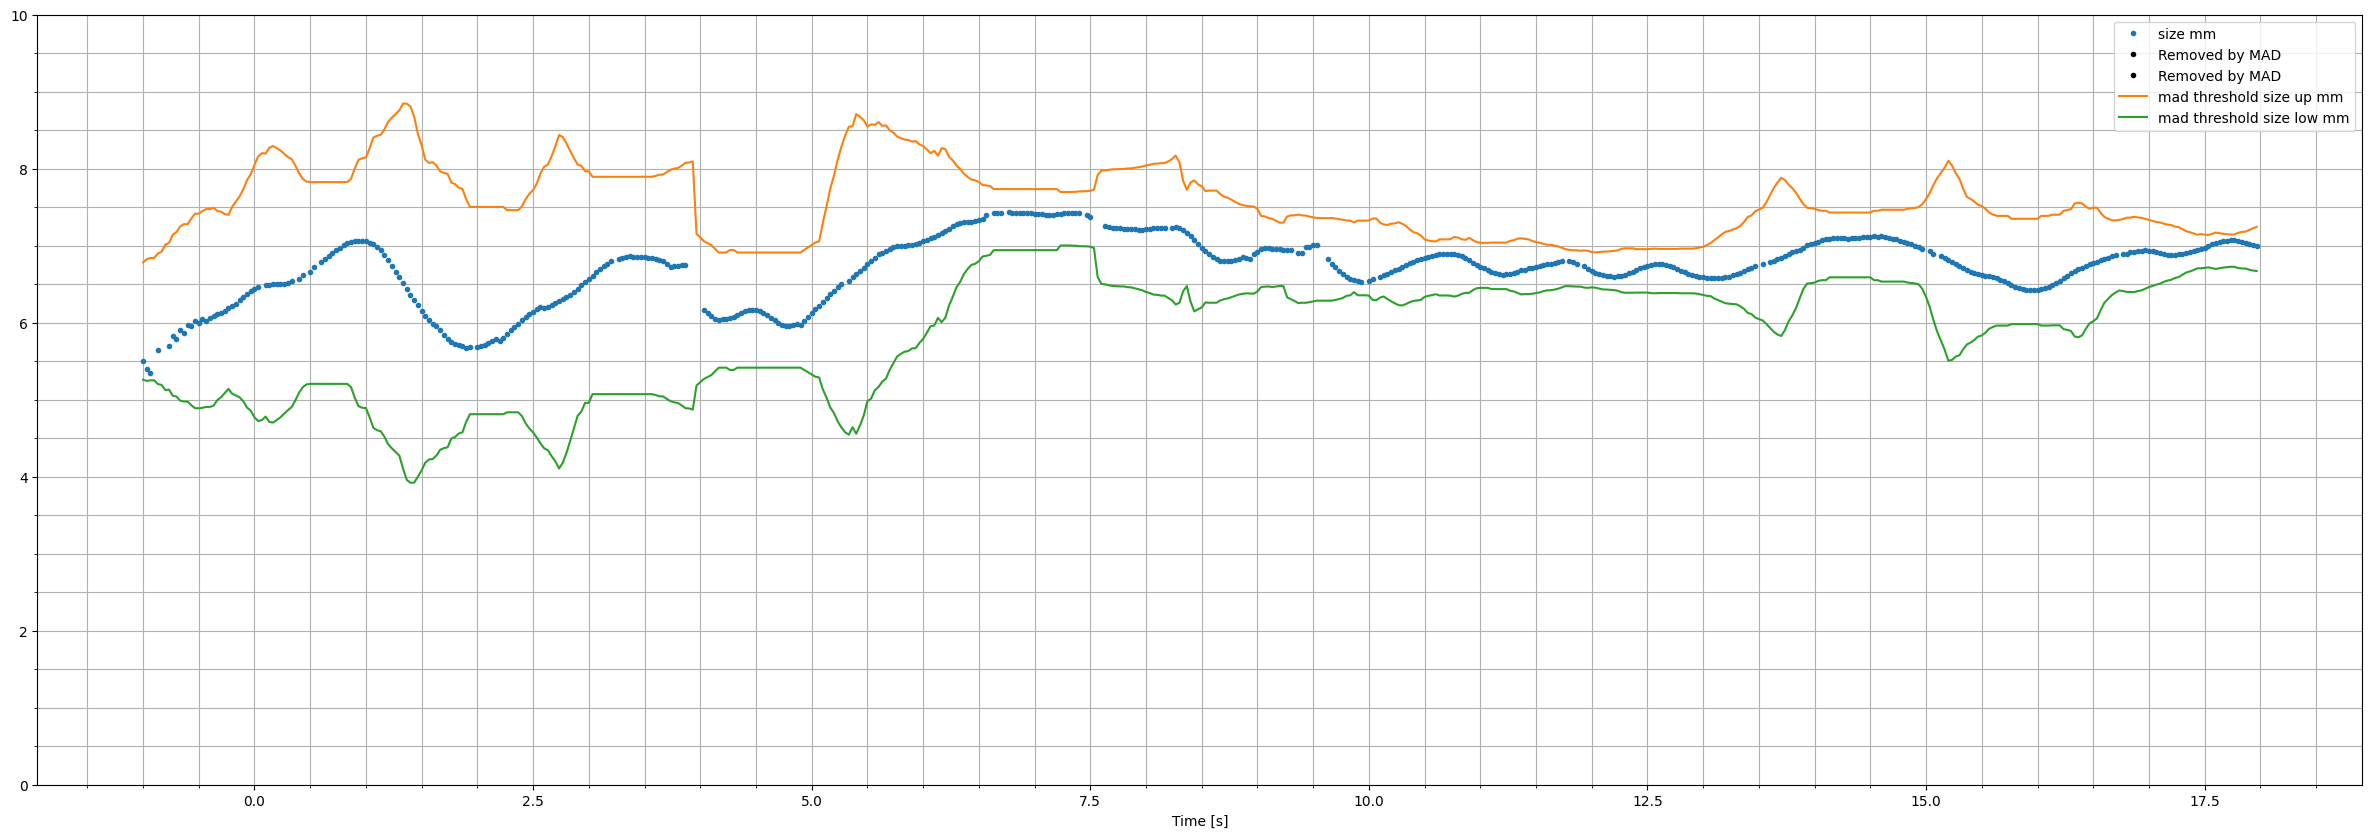

In [35]:
plot_trial_size_MAD(data_df, 20)

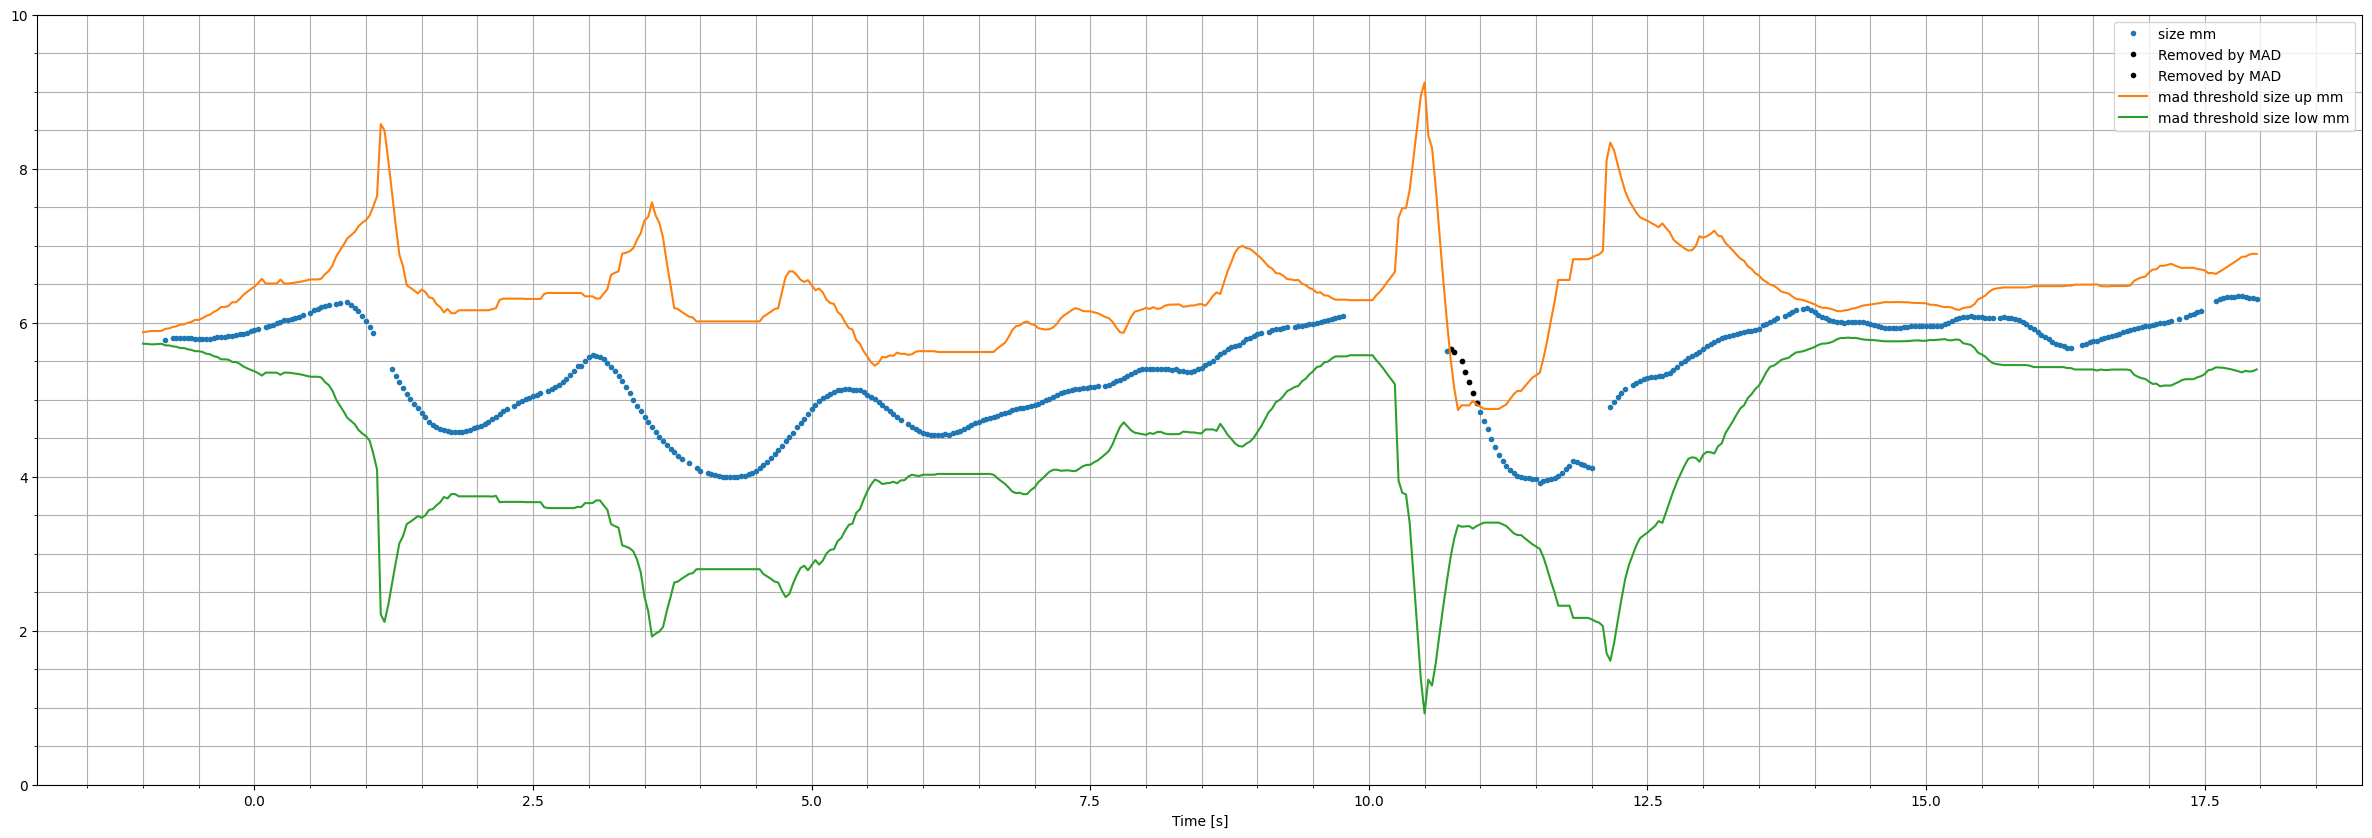

In [36]:
plot_trial_size_MAD(data_df, 435)

The choice of window size and multiplier seems to be appropriate, artifacts like for instance remnants of the spike at 12 seconds in the first plot or singular stray samples in the last plot are removed, while in other points improper removal is not readily observable. The one suspicious part of the signal that hasn't been removed is the part around 11 seconds in the last plot - U shaped sample sequence much lower than the general trend of the post-stimulus phase. However, it may also be an actual pupil measurement - there is a gap before it, so it may have been connected to a period with eyes closed, which may result in extra constriction upon re-opening.

Effectiveness of the algorithm and the specifics of window size/multiplier can be further evaluated in the EDA on artifact removal.

# <a id='toc5_'></a>[Conclusions: pipeline for artifact removal](#toc0_)

My recommended pipeline for artefact removal is:

1. Remove non-physiological measurements outside of 1.5-9 mm size range
2. Resample signal to 30 Hz
3. Remove pupil velocity artifacts using MAD in a rolling window of 60 samples with multiplier 4.5
4. Remove remaining pupil size artifacts using MAD calculated in a rolling window of 60 samples with multiplier 4.5

In the following section I will write the functions performing actual removal (as during development I wrote e.g. MAD calculation and removal separately to better test and showcase its effectiveness).

In [ ]:
def remove_artifacts_non_physio_size(data_df: pd.DataFrame):
    """Function setting the non-physiological pupil size values in either eye to NaN.

    Args:
        data_df (pd.DataFrame): dataframe for one participant loaded using loading_utils.load_participant_data

    Returns:
        pd.DataFrame: dataframe with non-physiological pupil sizes set to pd.NA
    """
    data_df.loc[
        (data_df["Right - Size Mm"] < 1.5) | (data_df["Right - Size Mm"] > 9),
        "Right - Size Mm",
    ] = pd.NA
    data_df.loc[
        (data_df["Left - Size Mm"] < 1.5) | (data_df["Left - Size Mm"] > 9),
        "Left - Size Mm",
    ] = pd.NA
    data_df.loc[
        (data_df["Stim eye - Size Mm"] < 1.5) | (data_df["Stim eye - Size Mm"] > 9),
        "Stim eye - Size Mm",
    ] = pd.NA
    return data_df


def remove_artefacts_rolling_velocity_mad(
    resampled_df: pd.DataFrame,
    multiplier: float = 4.5,
    window: int = 60,
    column: str = "Stim eye - Size Mm",
):
    """Function for removing artefacts based on median absolute deviation threshold for absolute pupil velocity.
    Calculates a threshold in a rolling window.

    Args:
        resampled_df (pd.DataFrame): resampled dataframe from preprocessing_utils.resample_by_trial
        multiplier (float, optional): multiplier for MAD threshold (median+multiplier*MAD). Defaults to 4.5.
        window (int, optional): rolling window size in samples. Defaults to 60.
        column (str,optional): column with signal to remove artifacts from. Defaults to 'Stim eye - Size Mm'.

    Returns:
        pd.DataFrame: dataframe with pupil size in stimulated eye set to pd.NA where velocity exceeds threshold.
    """

    resampled_df["Time diff"] = resampled_df["Trial time Sec"].diff()
    resampled_df["Size diff"] = resampled_df[column].diff()
    resampled_df.loc[resampled_df["Time diff"] < 0, "Size diff"] = pd.NA
    resampled_df.loc[resampled_df["Time diff"] < 0, "Time diff"] = pd.NA

    for trial_no in sorted(resampled_df["Trial no"].unique()):
        trial = resampled_df[resampled_df["Trial no"] == trial_no].copy()
        trial["Pupil velocity -1"] = abs(trial["Size diff"] / trial["Time diff"])
        trial["Pupil velocity +1"] = abs(
            trial["Size diff"].shift(-1) / trial["Time diff"].shift(-1)
        )
        trial["Pupil velocity"] = trial[["Pupil velocity -1", "Pupil velocity +1"]].max(
            axis="columns"
        )

        median = (
            trial["Pupil velocity"]
            .rolling(window=window, min_periods=1, center=True)
            .median()
        )

        mad = (
            trial["Pupil velocity"]
            .rolling(window=window, min_periods=1, center=True)
            .apply(lambda x: np.nanmedian(np.abs(x - np.nanmedian(x))), raw=True)
        )

        trial.loc[:, "MAD speed threshold"] = median + multiplier * mad
        resampled_df.loc[
            resampled_df["Trial no"] == trial_no, "MAD speed threshold"
        ] = trial["MAD speed threshold"]
        resampled_df.loc[resampled_df["Trial no"] == trial_no, "Pupil velocity"] = (
            trial["Pupil velocity"]
        )

    resampled_df.loc[
        ((resampled_df["Pupil velocity"] > resampled_df["MAD speed threshold"])),
        column,
    ] = pd.NA
    resampled_df = resampled_df.drop(columns=["Pupil velocity", "MAD speed threshold"])
    return resampled_df


def remove_artifacts_rolling_size_mad(
    resampled_df: pd.DataFrame,
    window: int = 60,
    multiplier: float = 4.5,
    column: str = "Stim eye - Size Mm",
):
    """Function for removing artifacts based on median absolute deviation threshold for pupil size. Calculates MAD in a rolling window.

    Args:
        resampled_df (pd.DataFrame): resampled dataframe from preprocessing_utils.resample_by_trial or with speed artifacts removed from remove_artifacts_phase_velocity_mad
        window (int): size of the rolling window in samples. Defaults to 60.
        multiplier (float, optional): multiplier for MAD threshold (median+/-multiplier*MAD). Defaults to 4.5.
        column (str, optional): Column with signal to remove artifacts from. Defaults to 'Stim eye - Size Mm'.

    Returns:
        pd.DataFrame: dataframe with pupil size samples out of MAD bounds replaced by pd.NA
    """

    for trial_no in sorted(resampled_df["Trial no"].unique()):
        trial = resampled_df[resampled_df["Trial no"] == trial_no].copy(deep=True)
        trial.reset_index(inplace=True)
        trial["MAD size threshold"] = pd.Series()

        median = (
            trial[column].rolling(window=window, min_periods=1, center=True).median()
        )

        mad = (
            trial[column]
            .rolling(window=window, min_periods=1, center=True)
            .apply(lambda x: np.nanmedian(np.abs(x - np.nanmedian(x))), raw=True)
        )

        trial.loc[:, "MAD size upper threshold"] = median + multiplier * mad
        trial.loc[:, "MAD size lower threshold"] = median - multiplier * mad

        resampled_df.loc[
            resampled_df["Trial no"] == trial_no, "MAD size upper threshold"
        ] = trial["MAD size upper threshold"].to_list()
        resampled_df.loc[
            resampled_df["Trial no"] == trial_no, "MAD size lower threshold"
        ] = trial["MAD size lower threshold"].to_list()

    resampled_df.loc[
        (
            (resampled_df[column] > resampled_df["MAD size upper threshold"])
            | (resampled_df[column] < resampled_df["MAD size lower threshold"])
        ),
        column,
    ] = pd.NA

    resampled_df = resampled_df.drop(
        columns=["MAD size upper threshold", "MAD size lower threshold"]
    )

    return resampled_df